# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°3: Influencia de las estrategias de muestreo de puntos de colocación
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc
from tqdm import trange

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


In [ ]:
# Crear un directorio para guardar las gráficas
graficas_dir = "graficas_tp3"

if not os.path.exists(graficas_dir):
    os.makedirs(graficas_dir)

### Clase PINN Navier-stokes

In [2]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow
    """
    
    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Re = model_parameters["Re"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        
        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) 
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        
        # Inicialización Xavier
        self.init_xavier()

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds
        
        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1
        
        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        
        return output

    def predict(self, X):
        """
        Predicción directa de u, v, p a partir de coordenadas (x, y).
        """
        uvp = self.forward(X)
        u = uvp[:, 0:1]
        v = uvp[:, 1:2]
        p = uvp[:, 2:3]
        return u, v, p

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        
        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión
        
        Re = self.Re
        
        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]
        
        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)
        
        # Residuo de continuidad
        residue_continuity = u_x + v_y
        
        return residue_u, residue_v, residue_continuity
    
    def compute_residual_norm(self, X):
        uvp = self.forward(X)
        r_u, r_v, _ = self.navierstokesResidue(X, uvp)
        residual_norm = (r_u ** 2 + r_v ** 2).squeeze()
        return residual_norm

#### Configuración del dominio y condiciones de borde

In [3]:
# Parámetros del problema
Re = 100.0  # Número de Reynolds
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Número de Reynolds: {Re}")
print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Número de Reynolds: 100.0
Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [4]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

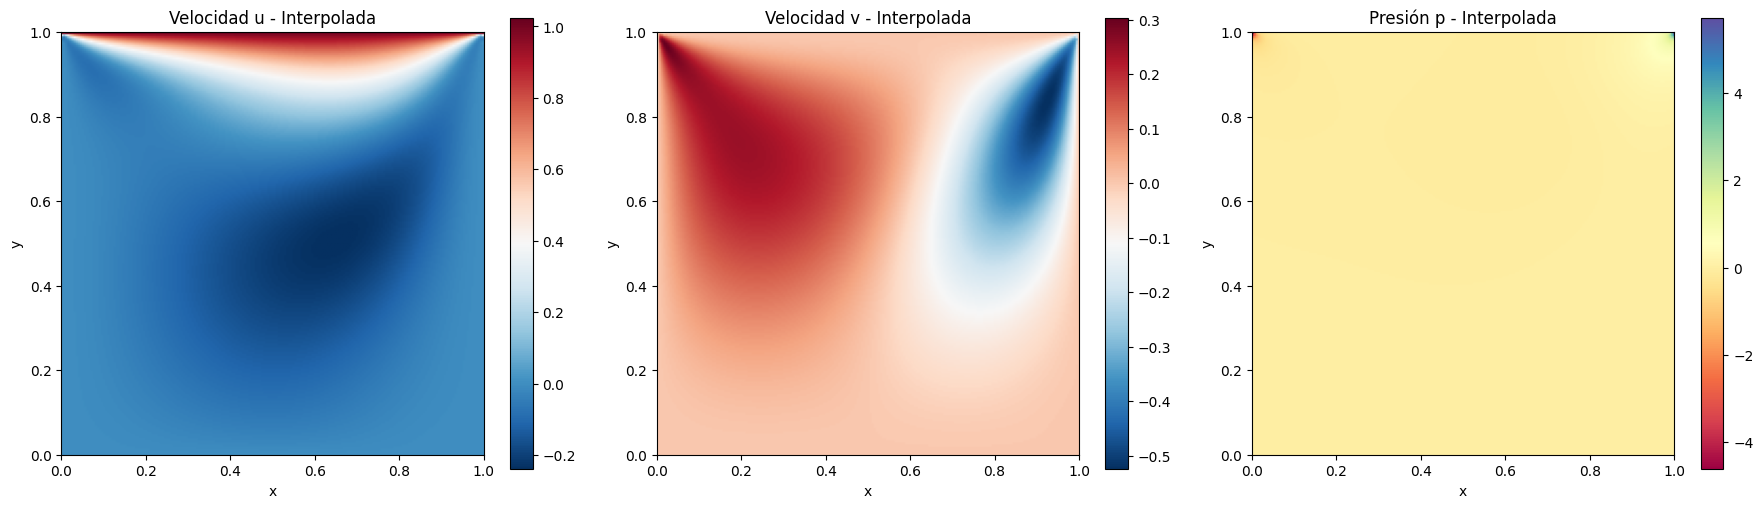

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

### 1. Estrategias de muestreo de puntos de colocación

*Para el modelo PINN desarrollado en el TP N°2, implementar las siguientes estrategias de muestreo para la construcción de los subconjuntos de puntos de colocación: muestreo aleatorio uniforme, muestreo por el método de hipercubo latino (LHS), y por muestreo adaptativo basado en residuos (estrategia RAD). En este último caso, utilice los residuos de las dos ecuaciones de balance de cantidad de movimiento como métrica para llevar a cabo la estrategia.*

#### (a) Muestreo aleatorio uniforme

In [6]:
def uniform_random_sampling(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs usando muestreo aleatorio uniforme.
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    # PDE points en el dominio [0,1] x [0,1]
    pde_points = torch.rand(N_pde, 2, device=device)

    # Puntos de borde
    N_each = N_bc // 4
    assert N_bc % 4 == 0, "N_bc debe ser divisible por 4 para distribuirlo en las 4 fronteras."
    rand = torch.rand(N_each, device=device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

#### (b) Muestreo por Hipercubo Latino (LHS)

In [7]:
def lhs_1d(N, device):
    """
    Realiza muestreo por hipercubo latino en 1D.
    Divide el intervalo [0,1] en N subintervalos y toma un punto aleatorio en cada uno,
    luego los mezcla aleatoriamente.
    """
    intervals = torch.linspace(0, 1, N + 1, device=device)
    lower_bounds = intervals[:-1]
    upper_bounds = intervals[1:]
    points = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(N, device=device)
    return points[torch.randperm(N)]

def latin_hypercube_sampling(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs usando muestreo por hipercubo latino (LHS).
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    x_pde = lhs_1d(N_pde, device)
    y_pde = lhs_1d(N_pde, device)
    pde_points = torch.stack([x_pde, y_pde], dim=1)

    N_each = N_bc // 4
    rand = lhs_1d(N_each, device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

#### (c) Muestreo adaptativo basado en residuos (RAD)

In [8]:
def residual_adaptive_sampling(model, N_pde, device, grid_N=None):
    """
    Genera puntos de colocación para PINNs usando muestreo adaptativo basado en residuos.
    Se asegura que haya suficientes puntos candidatos para seleccionar.
    """
    if grid_N is None:
        grid_N = max(2 * N_pde, 10000)  # mínimo 2*N_pde para garantizar topk

    test_points = torch.rand(grid_N, 2, device=device).requires_grad_(True)
    residual_norm = model.compute_residual_norm(test_points)

    # Asegurar que haya suficientes puntos para seleccionar
    if residual_norm.shape[0] < N_pde:
        raise ValueError(f"Intentando seleccionar {N_pde} puntos pero sólo hay {residual_norm.shape[0]} disponibles.")

    topk = torch.topk(residual_norm, N_pde)
    selected_points = test_points[topk.indices].detach()

    return selected_points

### 2. Para cada estrategia, preparar tres datasets con las siguientes cantidades de puntos.

- *Primer dataset con Npde = 1000 y Nbc = 100.*
- *Segundo dataset con Npde = 10000 y Nbc = 1000.*
- *Tercer dataset con Npde = 100000 y Nbc = 10000.*

Para resolver el punto 2, se implementa una función `generate_collocation_points()` que permite generar datasets de entrenamiento para las tres estrategias de muestreo requeridas: uniforme, hipercubo latino (LHS) y adaptativo por residuos (RAD), variando la cantidad de puntos de colocación según el enunciado. Se generan los datasets en loop dentro del entrenamiento mas adelante.

In [9]:
def generate_collocation_points(strategy, N_pde, N_bc, device, model=None):
    """
    Genera puntos de colocación para entrenamiento PINN según la estrategia indicada.
    
    Parámetros:
    - strategy: "uniform", "lhs" o "rad"
    - N_pde: cantidad de puntos interiores
    - N_bc: cantidad de puntos de borde
    - device: 'cpu' o 'cuda'
    - model: requerido solo si strategy="rad"

    Retorna:
    - pde_points, bottom, top, left, right, bc_points
    """
    if strategy == "uniform":
        return uniform_random_sampling(N_pde, N_bc, device)

    elif strategy == "lhs":
        return latin_hypercube_sampling(N_pde, N_bc, device)

    elif strategy == "rad":
        assert model is not None, "Se requiere un modelo entrenado para RAD."
        pde_points = residual_adaptive_sampling(model, N_pde, device)
        _, bottom, top, left, right, bc_points = uniform_random_sampling(0, N_bc, device)
        return pde_points, bottom, top, left, right, bc_points

    else:
        raise ValueError(f"Estrategia de muestreo desconocida: {strategy}")

In [10]:
strategies = ["uniform", "lhs", "rad"]
point_configs = [
    {"Npde": 1000, "Nbc": 100},
    {"Npde": 10000, "Nbc": 1000},
    {"Npde": 100000, "Nbc": 10000},
]

### 3. Entrenar el modelo PINN para las nueve configuraciones de datasets preparados en el item 2. 

*Con el fin de realizar una comparación “justa”, en todos los casos deberá utilizar la misma configuración de hiperparámetros (tamaño de red, optimizador, cantidad de epochs, etc.), y defina el criterio de selección de dichos valores. Utilice un valor 𝜆bc = 10 para el peso de la componente de la función de pérdida asociada al residuo de las condiciones de borde de velocidad. Calcular en cada caso la norma-2 del error de la misma manera que se realizó en el item 3 del TP N°2*

#### Configuración del modelo

In [11]:
# Parámetros del modelo: mantenemos igual a TP2
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": Re,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 48,    # Era 200 - REDUCIDO por CPU
    "NumberOfHiddenLayers": 6, # Era 12 - REDUCIDO por CPU
    "ActivationFunction": nn.GELU()
}

In [12]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 6
  - Neuronas por capa: 48
  - Función de activación: GELU(approximate='none')
  - Total de parámetros entrenables: 12051


### Entrenamiento

In [13]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

# Función para calcular pérdida de presión de referencia
def compute_pressure_reference_loss(model, loss_fn):
    """
    Calcula la pérdida para forzar que p(0,0) = 0
    Esto elimina la indeterminación de la constante en el campo de presión
    """
    # Punto de referencia (0,0)
    reference_point = torch.tensor([[0.0, 0.0]], device=device, requires_grad=True)
    
    # Evaluar el modelo en el punto de referencia
    uvp_ref = model(reference_point)
    p_ref = uvp_ref[:, 2:3]  # Extraer presión
    
    # La presión en (0,0) debe ser cero
    target_pressure = torch.zeros_like(p_ref)
    
    return loss_fn(p_ref, target_pressure)

# Función de entrenamiento
def train_pinn(model, pde_points, top, bottom, left, right, 
               epochs, optimizer, scheduler,
               weight_pde, lambda_bc, weight_pressure_ref,
               strategy=None, Npde=None, Nbc=None,
               loss_fn=nn.MSELoss()):
    """
    Entrena un modelo PINN para el problema de la cavidad cuadrada.
    Guarda el modelo con nombre basado en la estrategia y el tamaño del dataset.
    """
    # Historial de pérdidas
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    loss_train_pressure_ref = []

    print("Iniciando entrenamiento ...")
    t0 = datetime.now()

    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        model.train()
        optimizer.zero_grad()

        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)

        # Pérdidas PDE
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))
        loss_pde_total = loss_u + loss_v + loss_cont

        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)

        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)
        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right

        # === Presión de referencia ===
        loss_pressure_ref = compute_pressure_reference_loss(model, loss_fn)

        # === Pérdida total ===
        loss_total = (weight_pde * loss_pde_total +
                      lambda_bc * loss_bc_total +
                      weight_pressure_ref * loss_pressure_ref)

        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())
        loss_train_pressure_ref.append(loss_pressure_ref.item())

        # Logs
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
                ref_point = torch.tensor([[0.0, 0.0]], device=model.Device)
                p_ref_value = model(ref_point)[0, 2].item()

            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | P_ref: {loss_pressure_ref.item():.2e} | "
                  f"p(0,0): {p_ref_value:.4f} | u_top: {u_top_mean:.3f}")

    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    # Guardar modelo con nombre descriptivo
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"pinn_{strategy}_Npde{Npde}_Nbc{Nbc}_{time_str}.pt" if strategy and Npde and Nbc else f"pinn_trained_{time_str}.pt"
    torch.save(model.state_dict(), os.path.join(models_dir, filename))
    print(f"Modelo guardado como: models/{filename}")

    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc,
        "pressure_ref": loss_train_pressure_ref
    }


#### Gráficos de evolución de pérdidas

In [ ]:
# Función para graficar pérdidas con nueva pérdida
def plot_losses(loss_dict):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"],
        loss_dict["pressure_ref"]  # NUEVO
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta', 'orange']  # NUEVO color
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC', 'Pressure Ref']  # NUEVO título

    _, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    # Guardar la figura en el directorio graficas con nombre descriptivo
    plt.savefig(f"{graficas_dir}/perdidas_{strategy}_Npde{Npde}_Nbc{Nbc}.png")
    plt.show()

In [ ]:
def plot_comparacion_uvp(u_pred, v_pred, p_pred, strategy, Npde, Nbc,
                          U_grid, V_grid, P_grid, x, y):
    """
    Plotea comparación de u, v, p entre solución de referencia (MEF) y predicción (PINN),
    incluyendo errores absolutos. 
    
    MODIFICACIÓN: Escalas de colores sincronizadas para comparación visual precisa.
    
    Parámetros:
    - u_pred, v_pred, p_pred: resultados del modelo PINN (2D arrays)
    - strategy: nombre de la estrategia ('uniform', 'lhs', 'rad')
    - Npde, Nbc: tamaños del dataset
    - U_grid, V_grid, P_grid: campos de referencia (MEF)
    - x, y: arrays con coordenadas para los ejes
    """
    fig, axs = plt.subplots(3, 3, figsize=(18, 13))
    
    # Extensión para todas las gráficas
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    # --- Velocidad u ---
    im0 = axs[0, 0].imshow(U_grid, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[0, 0].set_title(r"$u_{MEF}$")
    axs[0, 0].set_ylabel("y")
    plt.colorbar(im0, ax=axs[0, 0])
    
    # PREDICCIÓN PINN u - ESCALA SINCRONIZADA
    im1 = axs[0, 1].imshow(u_pred, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal',
                           vmin=U_grid.min(), vmax=U_grid.max())  # ← SINCRONIZACIÓN
    axs[0, 1].set_title(r"$u_{PINN}$")
    plt.colorbar(im1, ax=axs[0, 1])
    
    im2 = axs[0, 2].imshow(np.abs(u_pred - U_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[0, 2].set_title(r"$|u_{PINN} - u_{MEF}|$")
    plt.colorbar(im2, ax=axs[0, 2])
    
    # --- Velocidad v ---
    im3 = axs[1, 0].imshow(V_grid, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[1, 0].set_title(r"$v_{MEF}$")
    axs[1, 0].set_ylabel("y")
    plt.colorbar(im3, ax=axs[1, 0])
    
    # PREDICCIÓN PINN v - ESCALA SINCRONIZADA
    im4 = axs[1, 1].imshow(v_pred, extent=extent,
                           origin='lower', cmap='RdBu_r', aspect='equal',
                           vmin=V_grid.min(), vmax=V_grid.max())  # ← SINCRONIZACIÓN
    axs[1, 1].set_title(r"$v_{PINN}$")
    plt.colorbar(im4, ax=axs[1, 1])
    
    im5 = axs[1, 2].imshow(np.abs(v_pred - V_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[1, 2].set_title(r"$|v_{PINN} - v_{MEF}|$")
    plt.colorbar(im5, ax=axs[1, 2])
    
    # --- Presión p ---
    im6 = axs[2, 0].imshow(P_grid, extent=extent,
                           origin='lower', cmap='Spectral', aspect='equal')
    axs[2, 0].set_title(r"$p_{MEF}$")
    axs[2, 0].set_ylabel("y")
    axs[2, 0].set_xlabel("x")
    plt.colorbar(im6, ax=axs[2, 0])
    
    # PREDICCIÓN PINN p - ESCALA SINCRONIZADA
    im7 = axs[2, 1].imshow(p_pred, extent=extent,
                           origin='lower', cmap='Spectral', aspect='equal',
                           vmin=P_grid.min(), vmax=P_grid.max())  # ← SINCRONIZACIÓN
    axs[2, 1].set_title(r"$p_{PINN}$")
    axs[2, 1].set_xlabel("x")
    plt.colorbar(im7, ax=axs[2, 1])
    
    im8 = axs[2, 2].imshow(np.abs(p_pred - P_grid), extent=extent,
                           origin='lower', cmap='Reds', aspect='equal')
    axs[2, 2].set_title(r"$|p_{PINN} - p_{MEF}|$")
    axs[2, 2].set_xlabel("x")
    plt.colorbar(im8, ax=axs[2, 2])
    
    plt.suptitle(f"Comparación de campos: {strategy.upper()} - Npde={Npde}, Nbc={Nbc}", 
                 fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # espacio para el título
    # Guardoramos la figura en el directorio graficas con nombre descriptivo
    if strategy is None or Npde is None or Nbc is None:
        plt.savefig(f"{graficas_dir}/comparacion_uvp_trained_model.png")
    else:
        # Guardamos con nombre descriptivo
        plt.savefig(f"{graficas_dir}/comparacion_uvp_{strategy}_Npde{Npde}_Nbc{Nbc}.png")

    plt.show()


=== Entrenando modelo: uniform_Npde1000_Nbc100 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<21:03,  7.92it/s]

Epoch    0 | Total: 1.02e+01 | PDE: 4.17e-01 | BC: 9.76e-01 | P_ref: 2.25e-02 | p(0,0): 0.2015 | u_top: 0.349


Entrenando modelo PINN:   5%|▌         | 509/10000 [00:09<03:06, 50.93it/s]

Epoch  500 | Total: 5.13e-01 | PDE: 1.10e-01 | BC: 4.04e-02 | P_ref: 1.46e-04 | p(0,0): -0.0067 | u_top: 1.012


Entrenando modelo PINN:  10%|█         | 1007/10000 [00:19<02:45, 54.48it/s]

Epoch 1000 | Total: 2.25e-01 | PDE: 2.92e-02 | BC: 1.95e-02 | P_ref: 3.96e-06 | p(0,0): -0.0015 | u_top: 0.948


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:28<03:01, 46.76it/s]

Epoch 1500 | Total: 1.39e-01 | PDE: 1.23e-02 | BC: 1.26e-02 | P_ref: 3.24e-09 | p(0,0): -0.0012 | u_top: 0.979


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:39<02:50, 46.95it/s]

Epoch 2000 | Total: 9.42e-02 | PDE: 8.72e-03 | BC: 8.54e-03 | P_ref: 1.66e-06 | p(0,0): -0.0006 | u_top: 0.978


Entrenando modelo PINN:  25%|██▌       | 2506/10000 [00:48<02:20, 53.34it/s]

Epoch 2500 | Total: 7.94e-02 | PDE: 1.07e-02 | BC: 6.87e-03 | P_ref: 1.74e-06 | p(0,0): -0.0002 | u_top: 0.981


Entrenando modelo PINN:  30%|███       | 3010/10000 [00:57<02:11, 53.03it/s]

Epoch 3000 | Total: 4.95e-02 | PDE: 5.54e-03 | BC: 4.39e-03 | P_ref: 3.62e-08 | p(0,0): -0.0002 | u_top: 0.987


Entrenando modelo PINN:  35%|███▌      | 3508/10000 [01:07<02:02, 53.10it/s]

Epoch 3500 | Total: 4.23e-02 | PDE: 4.67e-03 | BC: 3.76e-03 | P_ref: 3.70e-08 | p(0,0): -0.0000 | u_top: 1.006


Entrenando modelo PINN:  40%|████      | 4007/10000 [01:17<02:05, 47.73it/s]

Epoch 4000 | Total: 3.39e-02 | PDE: 3.27e-03 | BC: 3.06e-03 | P_ref: 3.45e-10 | p(0,0): 0.0001 | u_top: 0.989


Entrenando modelo PINN:  45%|████▌     | 4507/10000 [01:27<01:42, 53.83it/s]

Epoch 4500 | Total: 2.49e-02 | PDE: 2.70e-03 | BC: 2.22e-03 | P_ref: 1.83e-08 | p(0,0): -0.0001 | u_top: 0.997


Entrenando modelo PINN:  50%|█████     | 5008/10000 [01:37<01:39, 50.33it/s]

Epoch 5000 | Total: 2.76e-02 | PDE: 4.40e-03 | BC: 2.32e-03 | P_ref: 6.82e-09 | p(0,0): 0.0001 | u_top: 1.009


Entrenando modelo PINN:  55%|█████▌    | 5510/10000 [01:47<01:30, 49.81it/s]

Epoch 5500 | Total: 1.73e-02 | PDE: 2.80e-03 | BC: 1.45e-03 | P_ref: 4.99e-08 | p(0,0): -0.0001 | u_top: 1.005


Entrenando modelo PINN:  60%|██████    | 6010/10000 [01:57<01:20, 49.73it/s]

Epoch 6000 | Total: 1.17e-02 | PDE: 2.18e-03 | BC: 9.48e-04 | P_ref: 1.10e-08 | p(0,0): 0.0000 | u_top: 0.998


Entrenando modelo PINN:  65%|██████▌   | 6510/10000 [02:07<01:11, 48.60it/s]

Epoch 6500 | Total: 9.99e-03 | PDE: 2.40e-03 | BC: 7.59e-04 | P_ref: 1.52e-09 | p(0,0): -0.0001 | u_top: 1.003


Entrenando modelo PINN:  70%|███████   | 7010/10000 [02:17<01:00, 49.67it/s]

Epoch 7000 | Total: 7.27e-03 | PDE: 2.02e-03 | BC: 5.25e-04 | P_ref: 1.33e-10 | p(0,0): -0.0000 | u_top: 1.002


Entrenando modelo PINN:  75%|███████▌  | 7510/10000 [02:27<00:49, 50.37it/s]

Epoch 7500 | Total: 5.50e-03 | PDE: 1.71e-03 | BC: 3.78e-04 | P_ref: 1.12e-11 | p(0,0): -0.0000 | u_top: 1.000


Entrenando modelo PINN:  80%|████████  | 8007/10000 [02:37<00:39, 49.92it/s]

Epoch 8000 | Total: 4.80e-03 | PDE: 1.66e-03 | BC: 3.13e-04 | P_ref: 5.80e-11 | p(0,0): 0.0000 | u_top: 0.996


Entrenando modelo PINN:  85%|████████▌ | 8507/10000 [02:47<00:28, 52.86it/s]

Epoch 8500 | Total: 3.67e-03 | PDE: 1.38e-03 | BC: 2.29e-04 | P_ref: 1.08e-11 | p(0,0): -0.0000 | u_top: 0.999


Entrenando modelo PINN:  90%|█████████ | 9011/10000 [02:57<00:18, 54.20it/s]

Epoch 9000 | Total: 3.09e-03 | PDE: 1.25e-03 | BC: 1.84e-04 | P_ref: 2.17e-10 | p(0,0): 0.0000 | u_top: 0.999


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [03:06<00:10, 47.83it/s]

Epoch 9500 | Total: 2.73e-03 | PDE: 1.17e-03 | BC: 1.56e-04 | P_ref: 4.43e-10 | p(0,0): -0.0000 | u_top: 0.998


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:16<00:00, 50.93it/s]


Epoch 9999 | Total: 2.27e-03 | PDE: 1.04e-03 | BC: 1.22e-04 | P_ref: 1.35e-11 | p(0,0): -0.0000 | u_top: 1.000

Tiempo total: 196.4 segundos
Modelo guardado como: models/pinn_uniform_Npde1000_Nbc100_20250729_175321.pt
Plotting training losses for uniform_Npde1000_Nbc100


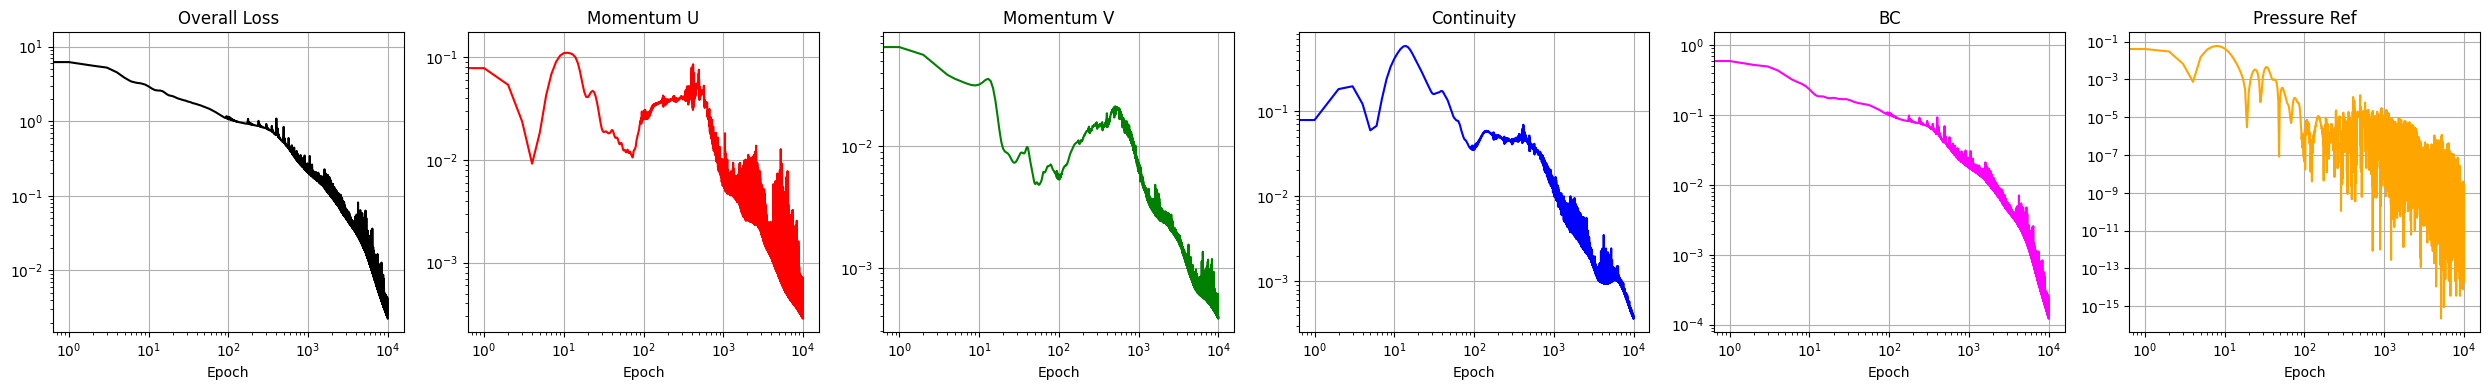

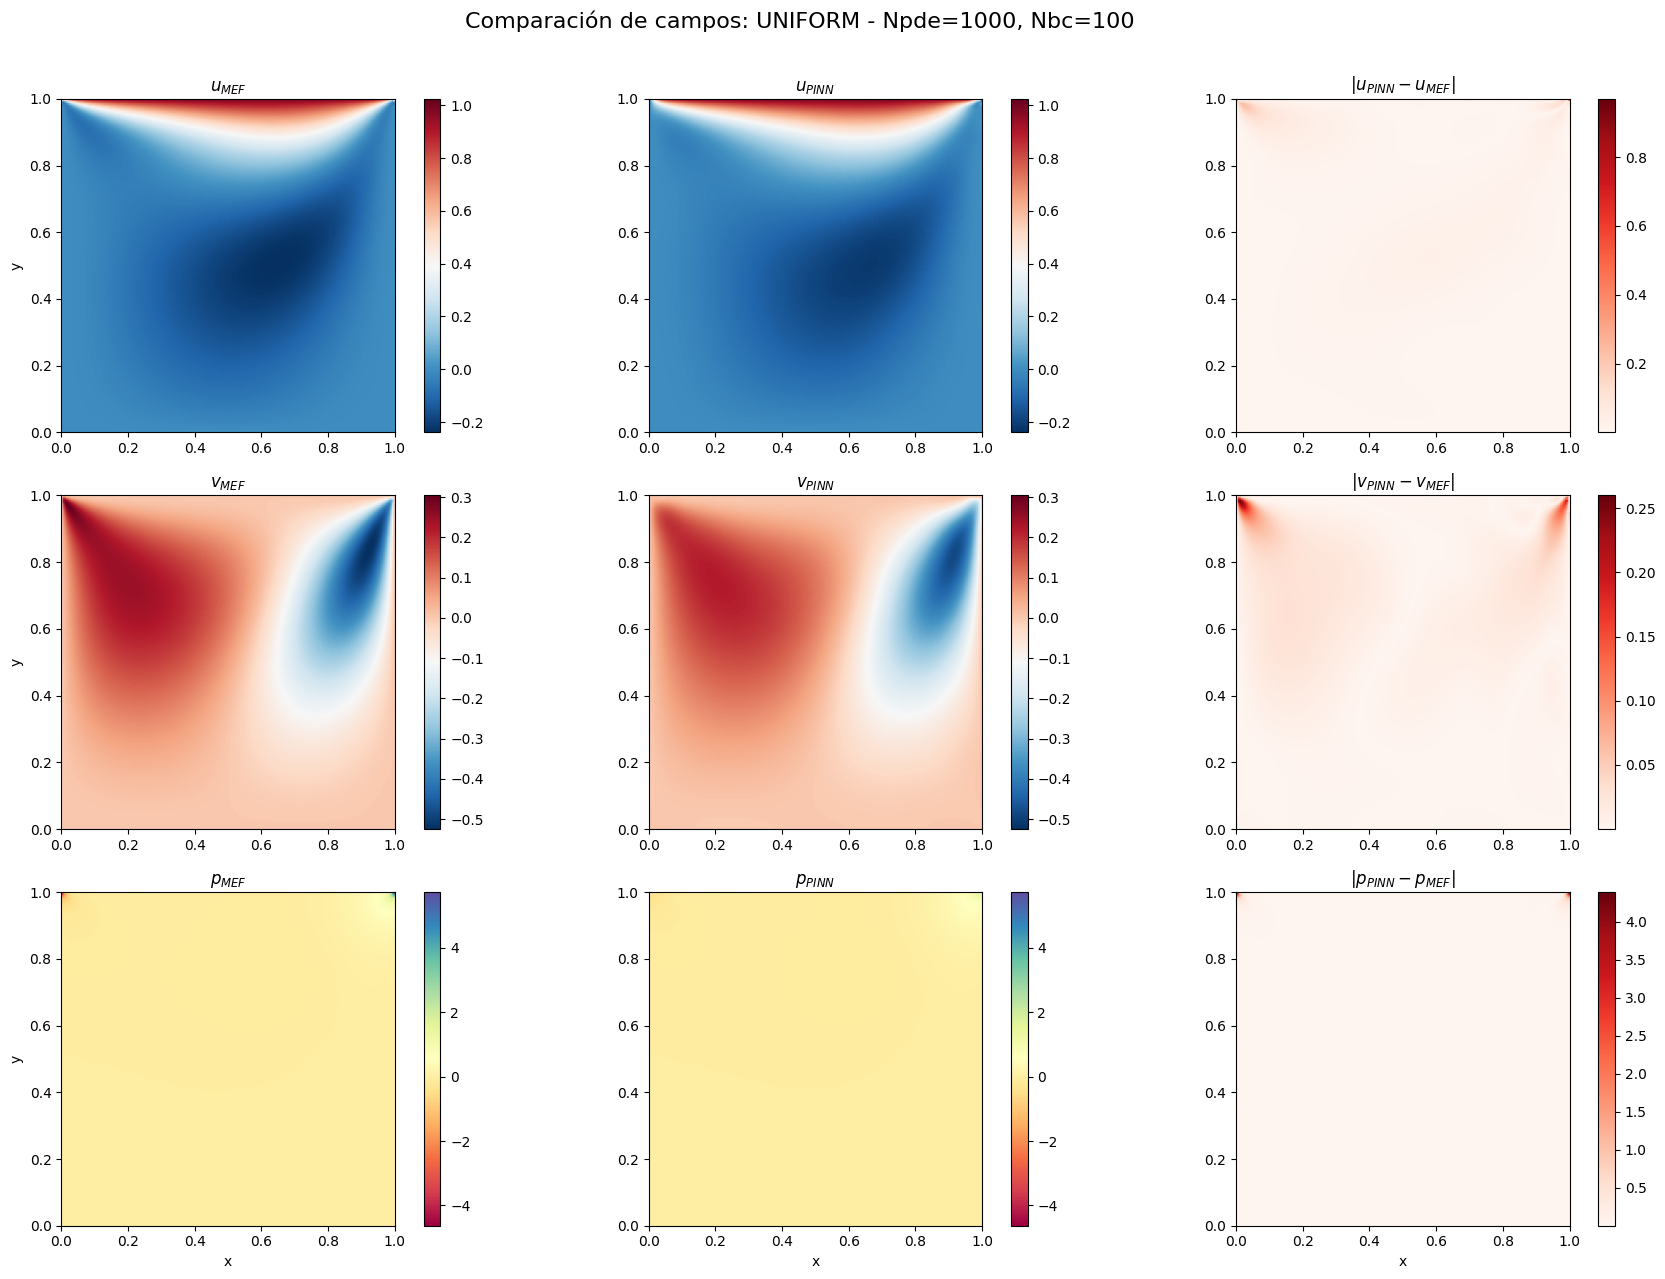


=== Entrenando modelo: uniform_Npde10000_Nbc1000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:40, 45.23it/s]

Epoch    0 | Total: 9.24e+00 | PDE: 4.10e-01 | BC: 8.81e-01 | P_ref: 2.25e-02 | p(0,0): 0.2197 | u_top: 0.377


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:10<03:11, 49.65it/s]

Epoch  500 | Total: 4.06e-01 | PDE: 4.61e-02 | BC: 3.60e-02 | P_ref: 7.73e-07 | p(0,0): 0.0009 | u_top: 0.968


Entrenando modelo PINN:  10%|█         | 1007/10000 [00:20<03:01, 49.64it/s]

Epoch 1000 | Total: 2.60e-01 | PDE: 3.52e-02 | BC: 2.24e-02 | P_ref: 9.09e-07 | p(0,0): -0.0031 | u_top: 0.969


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:30<02:51, 49.37it/s]

Epoch 1500 | Total: 1.73e-01 | PDE: 1.98e-02 | BC: 1.53e-02 | P_ref: 9.78e-07 | p(0,0): -0.0013 | u_top: 0.986


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:40<02:39, 50.06it/s]

Epoch 2000 | Total: 1.49e-01 | PDE: 1.37e-02 | BC: 1.36e-02 | P_ref: 1.17e-06 | p(0,0): 0.0010 | u_top: 1.007


Entrenando modelo PINN:  25%|██▌       | 2507/10000 [00:50<02:33, 48.86it/s]

Epoch 2500 | Total: 1.19e-01 | PDE: 1.14e-02 | BC: 1.08e-02 | P_ref: 2.62e-08 | p(0,0): -0.0001 | u_top: 0.993


Entrenando modelo PINN:  30%|███       | 3009/10000 [01:00<02:20, 49.91it/s]

Epoch 3000 | Total: 1.07e-01 | PDE: 1.09e-02 | BC: 9.61e-03 | P_ref: 3.15e-08 | p(0,0): -0.0005 | u_top: 0.981


Entrenando modelo PINN:  35%|███▌      | 3506/10000 [01:10<02:11, 49.34it/s]

Epoch 3500 | Total: 9.58e-02 | PDE: 9.98e-03 | BC: 8.58e-03 | P_ref: 1.86e-07 | p(0,0): 0.0000 | u_top: 0.996


Entrenando modelo PINN:  40%|████      | 4010/10000 [01:20<01:54, 52.53it/s]

Epoch 4000 | Total: 8.56e-02 | PDE: 8.99e-03 | BC: 7.66e-03 | P_ref: 2.99e-10 | p(0,0): -0.0004 | u_top: 1.002


Entrenando modelo PINN:  45%|████▌     | 4508/10000 [01:30<01:45, 52.27it/s]

Epoch 4500 | Total: 7.30e-02 | PDE: 8.84e-03 | BC: 6.42e-03 | P_ref: 4.01e-08 | p(0,0): -0.0007 | u_top: 0.992


Entrenando modelo PINN:  50%|█████     | 5006/10000 [01:39<01:36, 51.93it/s]

Epoch 5000 | Total: 6.47e-02 | PDE: 8.82e-03 | BC: 5.59e-03 | P_ref: 1.73e-07 | p(0,0): -0.0003 | u_top: 1.001


Entrenando modelo PINN:  55%|█████▌    | 5510/10000 [01:49<01:30, 49.68it/s]

Epoch 5500 | Total: 5.47e-02 | PDE: 7.90e-03 | BC: 4.68e-03 | P_ref: 1.41e-07 | p(0,0): -0.0003 | u_top: 0.992


Entrenando modelo PINN:  60%|██████    | 6007/10000 [01:59<01:20, 49.40it/s]

Epoch 6000 | Total: 4.93e-02 | PDE: 7.73e-03 | BC: 4.15e-03 | P_ref: 2.31e-07 | p(0,0): -0.0000 | u_top: 0.992


Entrenando modelo PINN:  65%|██████▌   | 6509/10000 [02:09<01:11, 48.98it/s]

Epoch 6500 | Total: 4.45e-02 | PDE: 7.25e-03 | BC: 3.72e-03 | P_ref: 1.26e-09 | p(0,0): -0.0001 | u_top: 0.997


Entrenando modelo PINN:  70%|███████   | 7008/10000 [02:19<01:00, 49.74it/s]

Epoch 7000 | Total: 4.02e-02 | PDE: 6.66e-03 | BC: 3.36e-03 | P_ref: 7.41e-08 | p(0,0): -0.0001 | u_top: 0.996


Entrenando modelo PINN:  75%|███████▌  | 7508/10000 [02:29<00:50, 49.59it/s]

Epoch 7500 | Total: 3.78e-02 | PDE: 6.59e-03 | BC: 3.12e-03 | P_ref: 1.23e-08 | p(0,0): -0.0002 | u_top: 0.992


Entrenando modelo PINN:  80%|████████  | 8007/10000 [02:39<00:40, 49.17it/s]

Epoch 8000 | Total: 3.39e-02 | PDE: 5.68e-03 | BC: 2.82e-03 | P_ref: 1.53e-09 | p(0,0): -0.0001 | u_top: 0.995


Entrenando modelo PINN:  85%|████████▌ | 8509/10000 [02:50<00:30, 49.45it/s]

Epoch 8500 | Total: 3.13e-02 | PDE: 5.16e-03 | BC: 2.62e-03 | P_ref: 6.04e-09 | p(0,0): -0.0001 | u_top: 0.996


Entrenando modelo PINN:  90%|█████████ | 9006/10000 [03:00<00:20, 49.68it/s]

Epoch 9000 | Total: 2.91e-02 | PDE: 4.72e-03 | BC: 2.44e-03 | P_ref: 1.12e-09 | p(0,0): 0.0000 | u_top: 0.995


Entrenando modelo PINN:  95%|█████████▌| 9506/10000 [03:10<00:10, 47.29it/s]

Epoch 9500 | Total: 2.70e-02 | PDE: 4.30e-03 | BC: 2.27e-03 | P_ref: 2.81e-11 | p(0,0): -0.0000 | u_top: 0.996


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:20<00:00, 49.90it/s]


Epoch 9999 | Total: 2.52e-02 | PDE: 3.93e-03 | BC: 2.13e-03 | P_ref: 6.47e-09 | p(0,0): 0.0000 | u_top: 0.997

Tiempo total: 200.4 segundos
Modelo guardado como: models/pinn_uniform_Npde10000_Nbc1000_20250729_175645.pt
Plotting training losses for uniform_Npde10000_Nbc1000


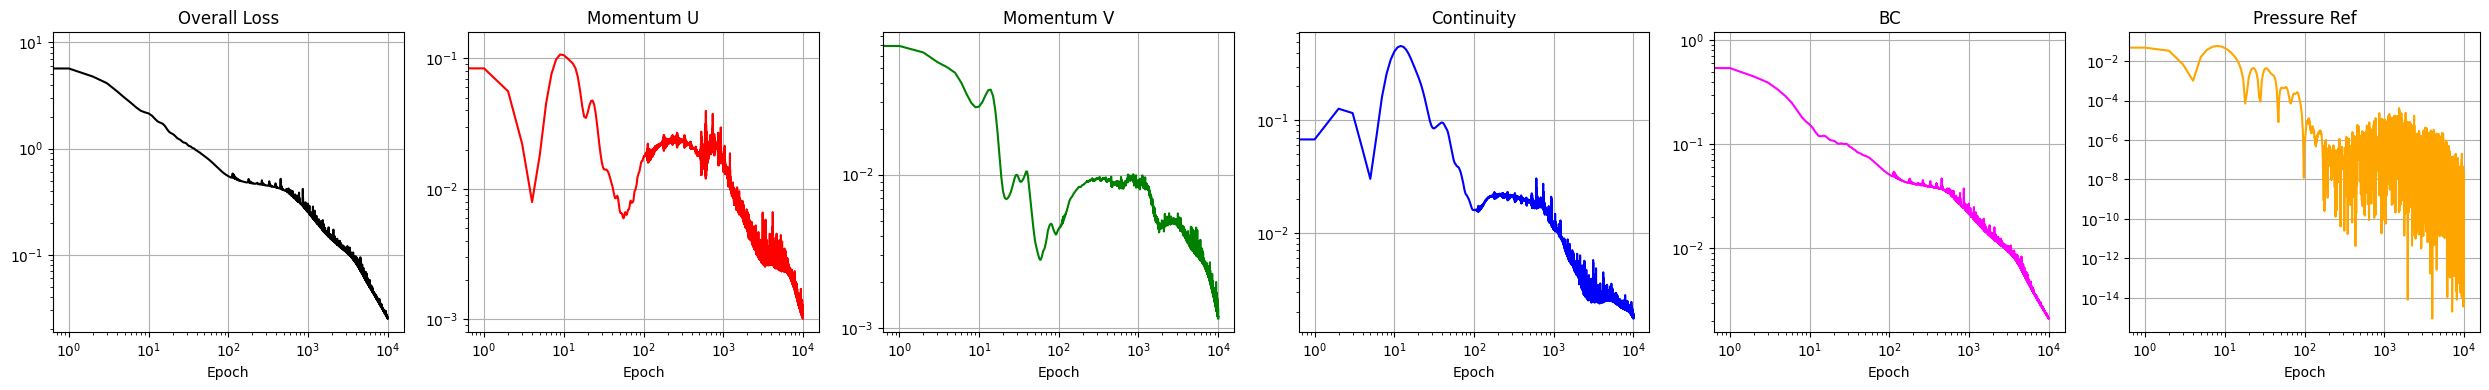

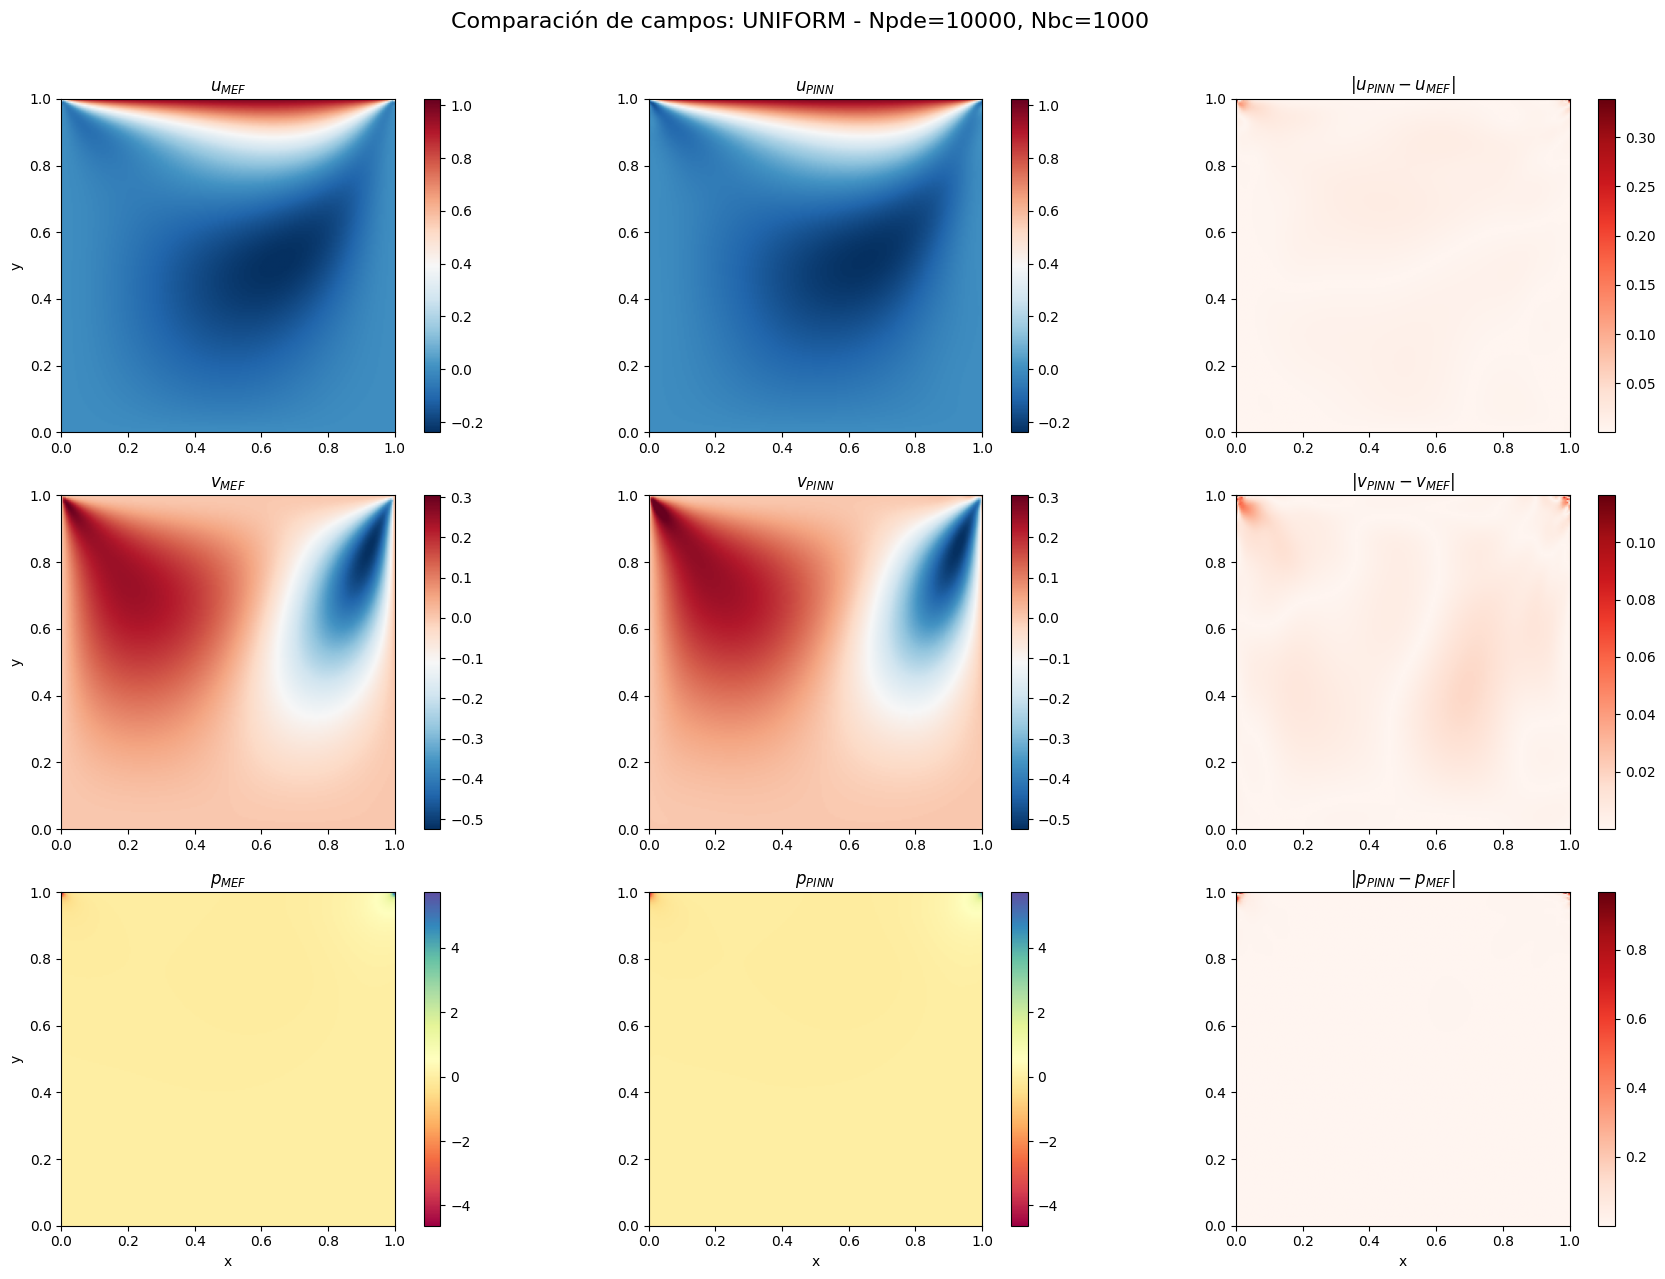


=== Entrenando modelo: uniform_Npde100000_Nbc10000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<19:39,  8.48it/s]

Epoch    0 | Total: 9.29e+00 | PDE: 4.07e-01 | BC: 8.86e-01 | P_ref: 2.25e-02 | p(0,0): 0.2205 | u_top: 0.376


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:54<17:22,  9.11it/s]

Epoch  500 | Total: 3.11e-01 | PDE: 5.28e-02 | BC: 2.58e-02 | P_ref: 2.43e-06 | p(0,0): -0.0000 | u_top: 0.933


Entrenando modelo PINN:  10%|█         | 1002/10000 [01:49<16:34,  9.05it/s]

Epoch 1000 | Total: 1.87e-01 | PDE: 3.24e-02 | BC: 1.55e-02 | P_ref: 9.92e-07 | p(0,0): -0.0009 | u_top: 0.980


Entrenando modelo PINN:  15%|█▌        | 1502/10000 [02:44<16:13,  8.73it/s]

Epoch 1500 | Total: 1.50e-01 | PDE: 1.94e-02 | BC: 1.31e-02 | P_ref: 9.41e-07 | p(0,0): -0.0023 | u_top: 1.004


Entrenando modelo PINN:  20%|██        | 2002/10000 [03:40<14:26,  9.23it/s]

Epoch 2000 | Total: 1.07e-01 | PDE: 1.25e-02 | BC: 9.45e-03 | P_ref: 4.96e-07 | p(0,0): -0.0006 | u_top: 0.990


Entrenando modelo PINN:  25%|██▌       | 2502/10000 [04:35<13:44,  9.10it/s]

Epoch 2500 | Total: 1.03e-01 | PDE: 9.97e-03 | BC: 9.32e-03 | P_ref: 5.04e-07 | p(0,0): -0.0011 | u_top: 1.011


Entrenando modelo PINN:  30%|███       | 3002/10000 [05:30<12:50,  9.08it/s]

Epoch 3000 | Total: 8.19e-02 | PDE: 8.92e-03 | BC: 7.29e-03 | P_ref: 2.99e-07 | p(0,0): 0.0005 | u_top: 0.984


Entrenando modelo PINN:  35%|███▌      | 3502/10000 [06:26<12:13,  8.86it/s]

Epoch 3500 | Total: 7.73e-02 | PDE: 8.16e-03 | BC: 6.91e-03 | P_ref: 2.34e-06 | p(0,0): -0.0006 | u_top: 0.999


Entrenando modelo PINN:  40%|████      | 4002/10000 [07:22<11:08,  8.98it/s]

Epoch 4000 | Total: 6.75e-02 | PDE: 7.34e-03 | BC: 6.01e-03 | P_ref: 2.88e-09 | p(0,0): -0.0000 | u_top: 0.991


Entrenando modelo PINN:  45%|████▌     | 4502/10000 [08:18<10:07,  9.04it/s]

Epoch 4500 | Total: 6.31e-02 | PDE: 6.99e-03 | BC: 5.61e-03 | P_ref: 1.33e-07 | p(0,0): 0.0004 | u_top: 0.992


Entrenando modelo PINN:  50%|█████     | 5002/10000 [09:14<09:17,  8.96it/s]

Epoch 5000 | Total: 5.87e-02 | PDE: 6.23e-03 | BC: 5.25e-03 | P_ref: 4.99e-10 | p(0,0): -0.0000 | u_top: 0.994


Entrenando modelo PINN:  55%|█████▌    | 5502/10000 [10:09<08:22,  8.94it/s]

Epoch 5500 | Total: 5.56e-02 | PDE: 5.77e-03 | BC: 4.98e-03 | P_ref: 2.14e-07 | p(0,0): -0.0004 | u_top: 0.997


Entrenando modelo PINN:  60%|██████    | 6002/10000 [11:05<07:27,  8.93it/s]

Epoch 6000 | Total: 5.22e-02 | PDE: 5.40e-03 | BC: 4.68e-03 | P_ref: 5.90e-08 | p(0,0): -0.0002 | u_top: 0.993


Entrenando modelo PINN:  65%|██████▌   | 6502/10000 [12:01<06:41,  8.71it/s]

Epoch 6500 | Total: 4.96e-02 | PDE: 4.93e-03 | BC: 4.47e-03 | P_ref: 4.57e-10 | p(0,0): 0.0001 | u_top: 0.995


Entrenando modelo PINN:  70%|███████   | 7002/10000 [12:58<05:31,  9.04it/s]

Epoch 7000 | Total: 4.73e-02 | PDE: 4.68e-03 | BC: 4.26e-03 | P_ref: 1.97e-08 | p(0,0): -0.0000 | u_top: 0.996


Entrenando modelo PINN:  75%|███████▌  | 7502/10000 [13:53<04:38,  8.96it/s]

Epoch 7500 | Total: 4.52e-02 | PDE: 4.43e-03 | BC: 4.08e-03 | P_ref: 5.45e-09 | p(0,0): 0.0002 | u_top: 0.995


Entrenando modelo PINN:  80%|████████  | 8002/10000 [14:48<03:41,  9.04it/s]

Epoch 8000 | Total: 4.37e-02 | PDE: 4.25e-03 | BC: 3.95e-03 | P_ref: 1.80e-08 | p(0,0): -0.0000 | u_top: 0.998


Entrenando modelo PINN:  85%|████████▌ | 8502/10000 [15:44<02:46,  9.00it/s]

Epoch 8500 | Total: 4.19e-02 | PDE: 4.00e-03 | BC: 3.79e-03 | P_ref: 4.09e-08 | p(0,0): 0.0002 | u_top: 0.998


Entrenando modelo PINN:  90%|█████████ | 9002/10000 [16:39<01:50,  9.04it/s]

Epoch 9000 | Total: 4.04e-02 | PDE: 3.93e-03 | BC: 3.65e-03 | P_ref: 4.74e-08 | p(0,0): 0.0002 | u_top: 0.996


Entrenando modelo PINN:  95%|█████████▌| 9502/10000 [17:34<00:55,  9.01it/s]

Epoch 9500 | Total: 3.92e-02 | PDE: 3.86e-03 | BC: 3.53e-03 | P_ref: 3.42e-09 | p(0,0): -0.0001 | u_top: 0.997


Entrenando modelo PINN: 100%|██████████| 10000/10000 [18:29<00:00,  9.01it/s]


Epoch 9999 | Total: 3.80e-02 | PDE: 3.68e-03 | BC: 3.43e-03 | P_ref: 2.96e-09 | p(0,0): 0.0000 | u_top: 0.996

Tiempo total: 1109.8 segundos
Modelo guardado como: models/pinn_uniform_Npde100000_Nbc10000_20250729_181519.pt
Plotting training losses for uniform_Npde100000_Nbc10000


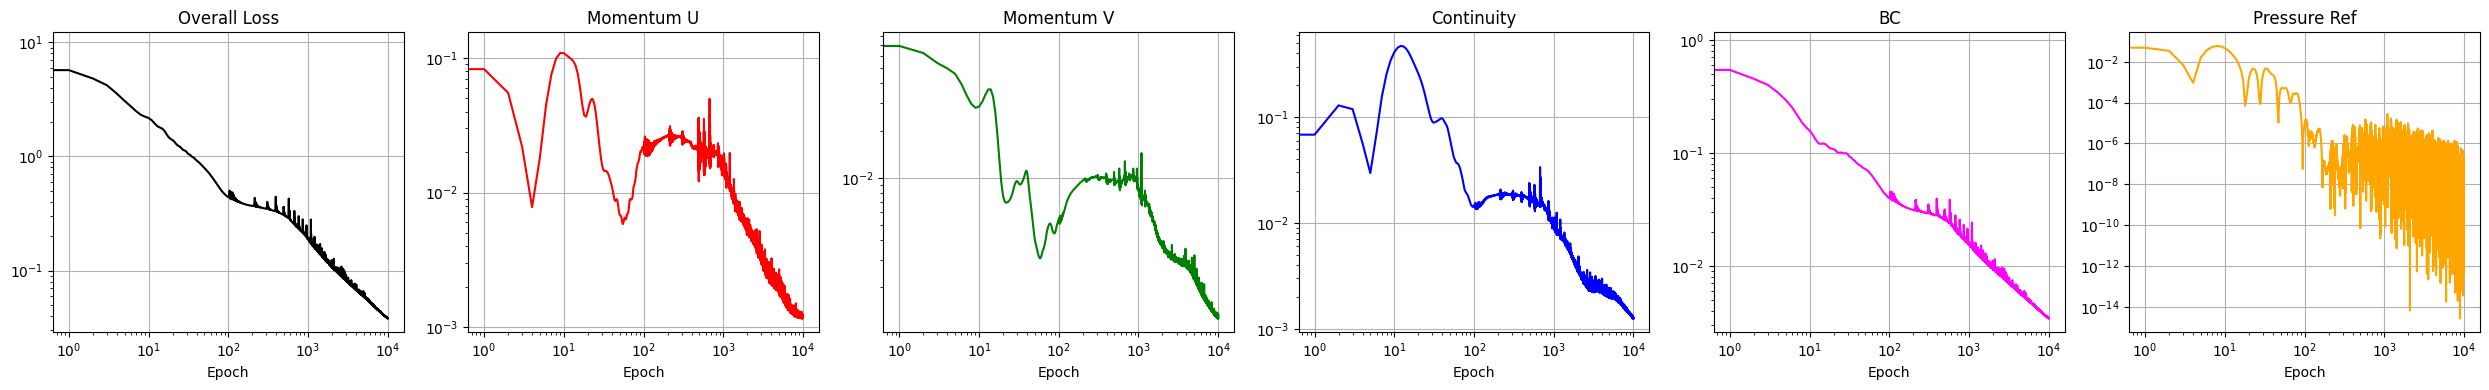

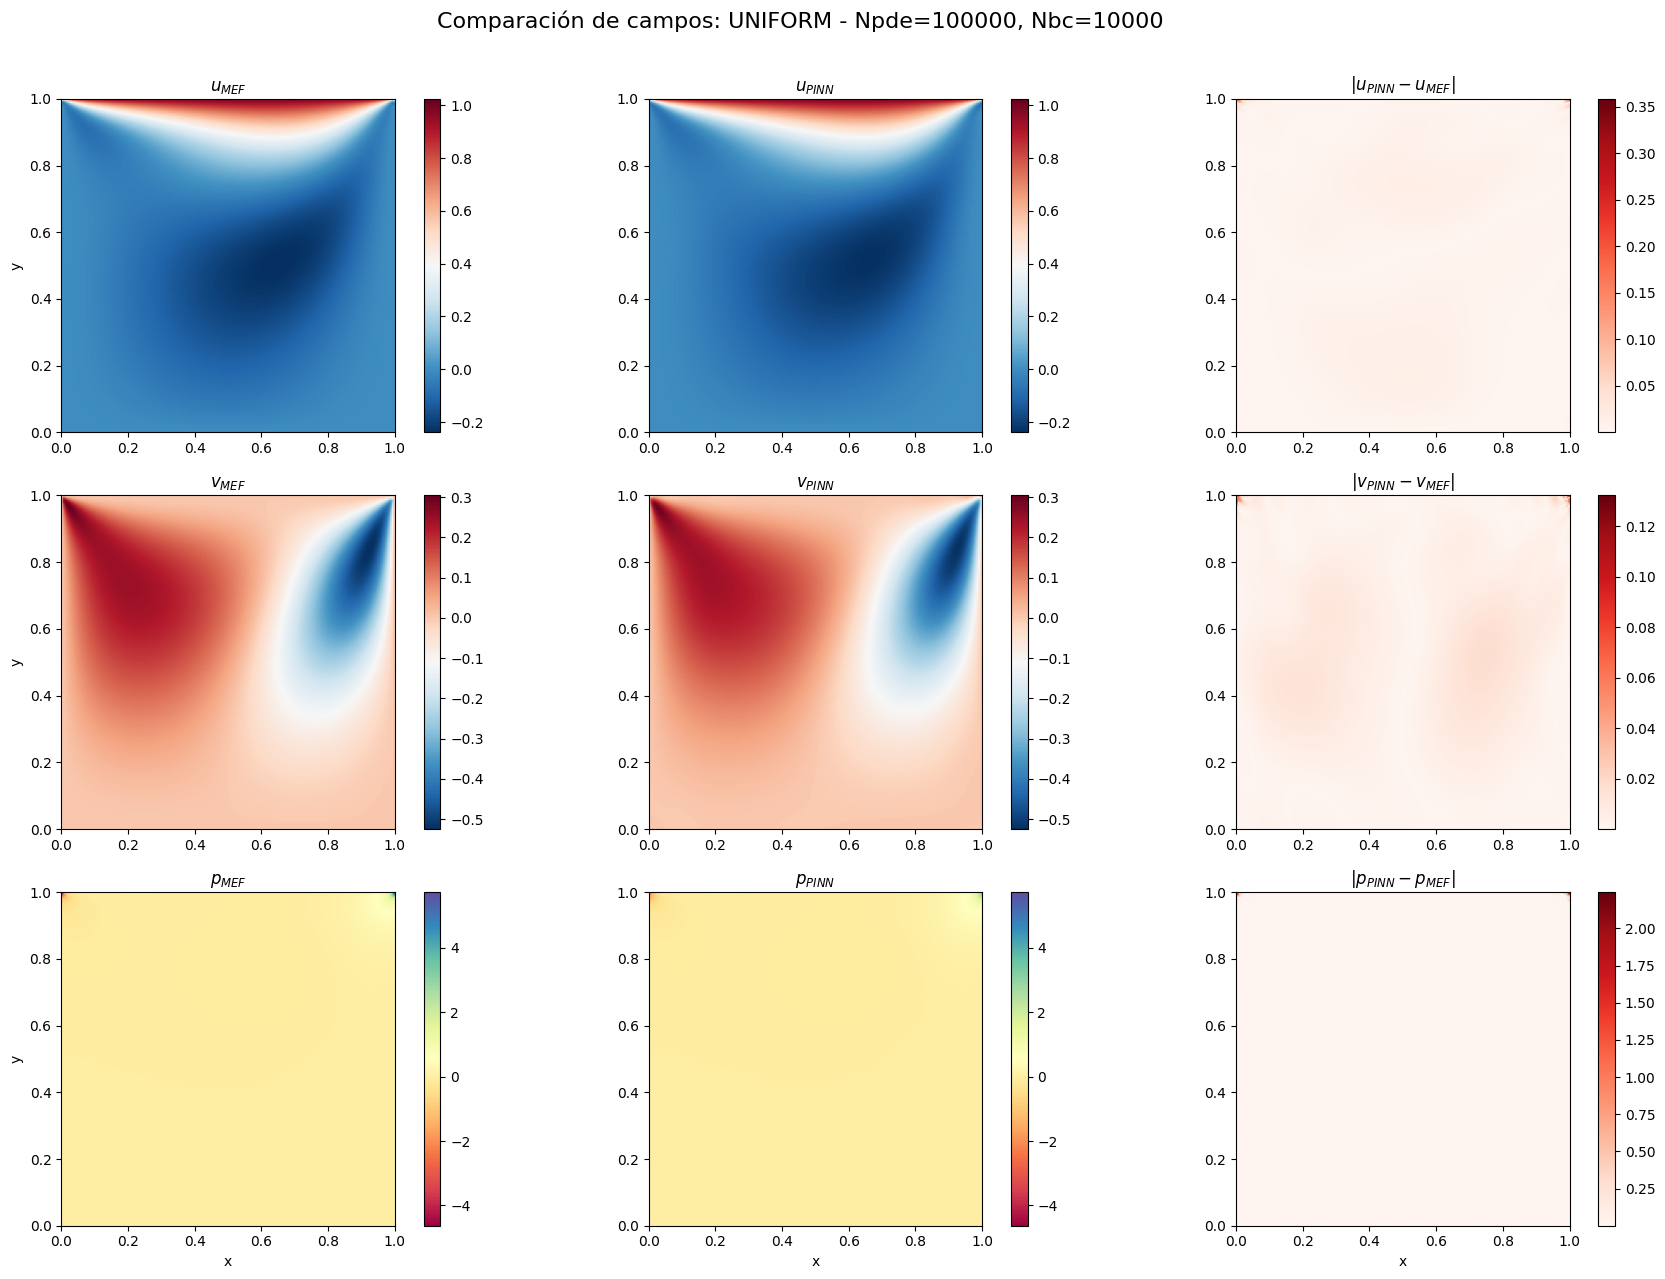


=== Entrenando modelo: lhs_Npde1000_Nbc100 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:29, 47.67it/s]

Epoch    0 | Total: 9.41e+00 | PDE: 4.27e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2198 | u_top: 0.371


Entrenando modelo PINN:   5%|▌         | 510/10000 [00:09<03:04, 51.41it/s]

Epoch  500 | Total: 3.01e-01 | PDE: 5.68e-02 | BC: 2.44e-02 | P_ref: 1.49e-06 | p(0,0): -0.0013 | u_top: 0.943


Entrenando modelo PINN:  10%|█         | 1008/10000 [00:19<02:51, 52.32it/s]

Epoch 1000 | Total: 5.01e-02 | PDE: 1.90e-02 | BC: 3.11e-03 | P_ref: 2.98e-08 | p(0,0): -0.0003 | u_top: 1.002


Entrenando modelo PINN:  15%|█▌        | 1506/10000 [00:28<02:40, 53.04it/s]

Epoch 1500 | Total: 1.71e-02 | PDE: 9.00e-03 | BC: 8.10e-04 | P_ref: 1.16e-07 | p(0,0): -0.0002 | u_top: 1.001


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:38<02:30, 53.26it/s]

Epoch 2000 | Total: 1.68e-02 | PDE: 6.20e-03 | BC: 1.06e-03 | P_ref: 2.58e-08 | p(0,0): -0.0001 | u_top: 1.008


Entrenando modelo PINN:  25%|██▌       | 2508/10000 [00:47<02:16, 54.83it/s]

Epoch 2500 | Total: 5.50e-03 | PDE: 3.01e-03 | BC: 2.49e-04 | P_ref: 6.46e-10 | p(0,0): -0.0001 | u_top: 0.995


Entrenando modelo PINN:  30%|███       | 3006/10000 [00:56<02:09, 54.12it/s]

Epoch 3000 | Total: 4.30e-03 | PDE: 2.44e-03 | BC: 1.86e-04 | P_ref: 4.30e-07 | p(0,0): 0.0004 | u_top: 1.000


Entrenando modelo PINN:  35%|███▌      | 3510/10000 [01:06<02:01, 53.59it/s]

Epoch 3500 | Total: 2.65e-03 | PDE: 1.62e-03 | BC: 1.03e-04 | P_ref: 4.90e-08 | p(0,0): -0.0001 | u_top: 1.000


Entrenando modelo PINN:  40%|████      | 4008/10000 [01:15<01:50, 54.32it/s]

Epoch 4000 | Total: 2.05e-03 | PDE: 1.27e-03 | BC: 7.82e-05 | P_ref: 4.22e-09 | p(0,0): -0.0001 | u_top: 0.999


Entrenando modelo PINN:  45%|████▌     | 4509/10000 [01:25<01:54, 47.92it/s]

Epoch 4500 | Total: 2.82e-03 | PDE: 1.27e-03 | BC: 1.55e-04 | P_ref: 1.18e-09 | p(0,0): -0.0000 | u_top: 1.007


Entrenando modelo PINN:  50%|█████     | 5007/10000 [01:35<01:41, 49.18it/s]

Epoch 5000 | Total: 1.39e-03 | PDE: 9.05e-04 | BC: 4.88e-05 | P_ref: 9.77e-10 | p(0,0): 0.0000 | u_top: 0.999


Entrenando modelo PINN:  55%|█████▌    | 5506/10000 [01:45<01:29, 50.14it/s]

Epoch 5500 | Total: 1.16e-03 | PDE: 7.62e-04 | BC: 3.97e-05 | P_ref: 5.18e-11 | p(0,0): -0.0000 | u_top: 1.000


Entrenando modelo PINN:  60%|██████    | 6011/10000 [01:55<01:13, 54.24it/s]

Epoch 6000 | Total: 1.04e-03 | PDE: 6.68e-04 | BC: 3.69e-05 | P_ref: 2.77e-12 | p(0,0): -0.0000 | u_top: 1.001


Entrenando modelo PINN:  65%|██████▌   | 6509/10000 [02:05<01:07, 52.04it/s]

Epoch 6500 | Total: 1.03e-03 | PDE: 5.98e-04 | BC: 4.28e-05 | P_ref: 3.79e-10 | p(0,0): -0.0000 | u_top: 1.003


Entrenando modelo PINN:  70%|███████   | 7011/10000 [02:15<00:59, 49.91it/s]

Epoch 7000 | Total: 7.74e-04 | PDE: 5.37e-04 | BC: 2.37e-05 | P_ref: 2.69e-14 | p(0,0): -0.0000 | u_top: 1.000


Entrenando modelo PINN:  75%|███████▌  | 7506/10000 [02:25<00:49, 50.00it/s]

Epoch 7500 | Total: 7.00e-04 | PDE: 4.91e-04 | BC: 2.09e-05 | P_ref: 7.80e-11 | p(0,0): -0.0000 | u_top: 1.000


Entrenando modelo PINN:  80%|████████  | 8006/10000 [02:35<00:40, 49.80it/s]

Epoch 8000 | Total: 6.35e-04 | PDE: 4.49e-04 | BC: 1.86e-05 | P_ref: 7.27e-12 | p(0,0): 0.0000 | u_top: 1.000


Entrenando modelo PINN:  85%|████████▌ | 8507/10000 [02:45<00:29, 49.92it/s]

Epoch 8500 | Total: 7.47e-04 | PDE: 4.27e-04 | BC: 3.20e-05 | P_ref: 6.80e-10 | p(0,0): 0.0000 | u_top: 0.997


Entrenando modelo PINN:  90%|█████████ | 9006/10000 [02:55<00:19, 50.24it/s]

Epoch 9000 | Total: 5.38e-04 | PDE: 3.86e-04 | BC: 1.52e-05 | P_ref: 1.11e-11 | p(0,0): 0.0000 | u_top: 1.000


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [03:05<00:09, 49.96it/s]

Epoch 9500 | Total: 5.13e-04 | PDE: 3.62e-04 | BC: 1.51e-05 | P_ref: 1.10e-13 | p(0,0): 0.0000 | u_top: 0.999


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:15<00:00, 51.19it/s]


Epoch 9999 | Total: 4.70e-04 | PDE: 3.41e-04 | BC: 1.29e-05 | P_ref: 1.56e-10 | p(0,0): -0.0000 | u_top: 1.000

Tiempo total: 195.3 segundos
Modelo guardado como: models/pinn_lhs_Npde1000_Nbc100_20250729_181838.pt
Plotting training losses for lhs_Npde1000_Nbc100


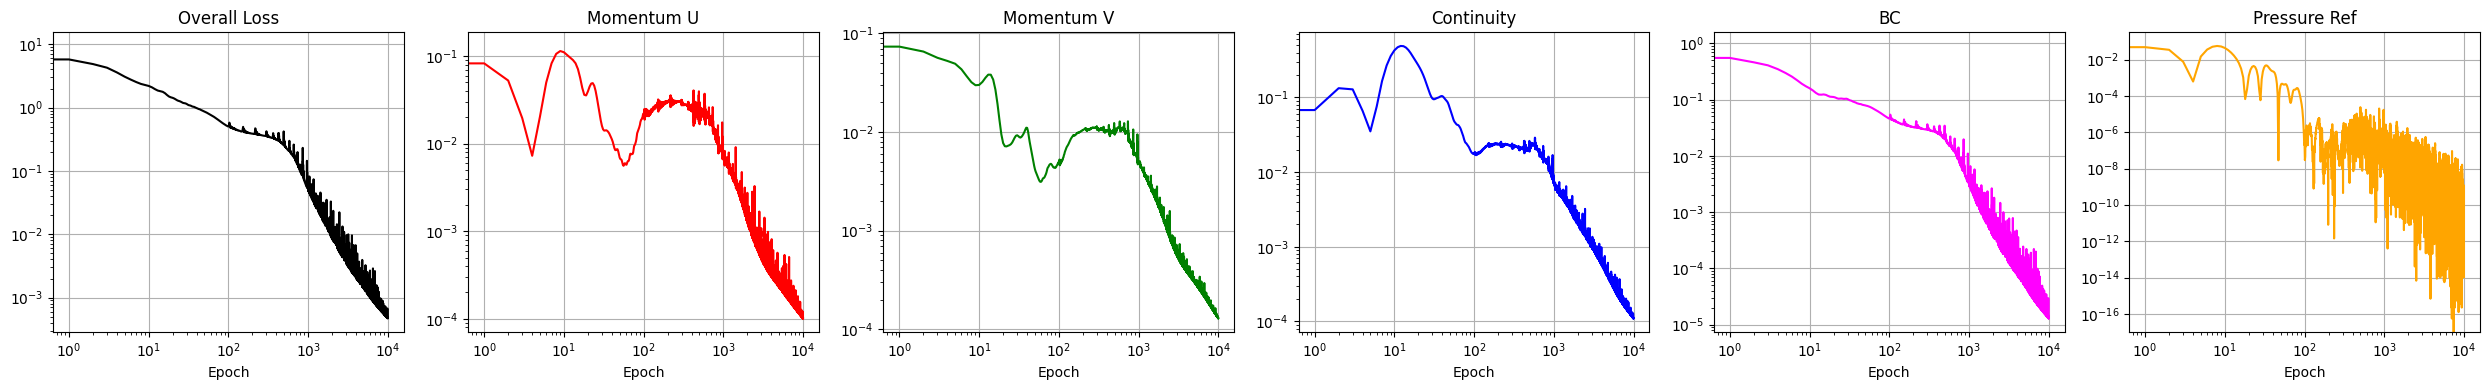

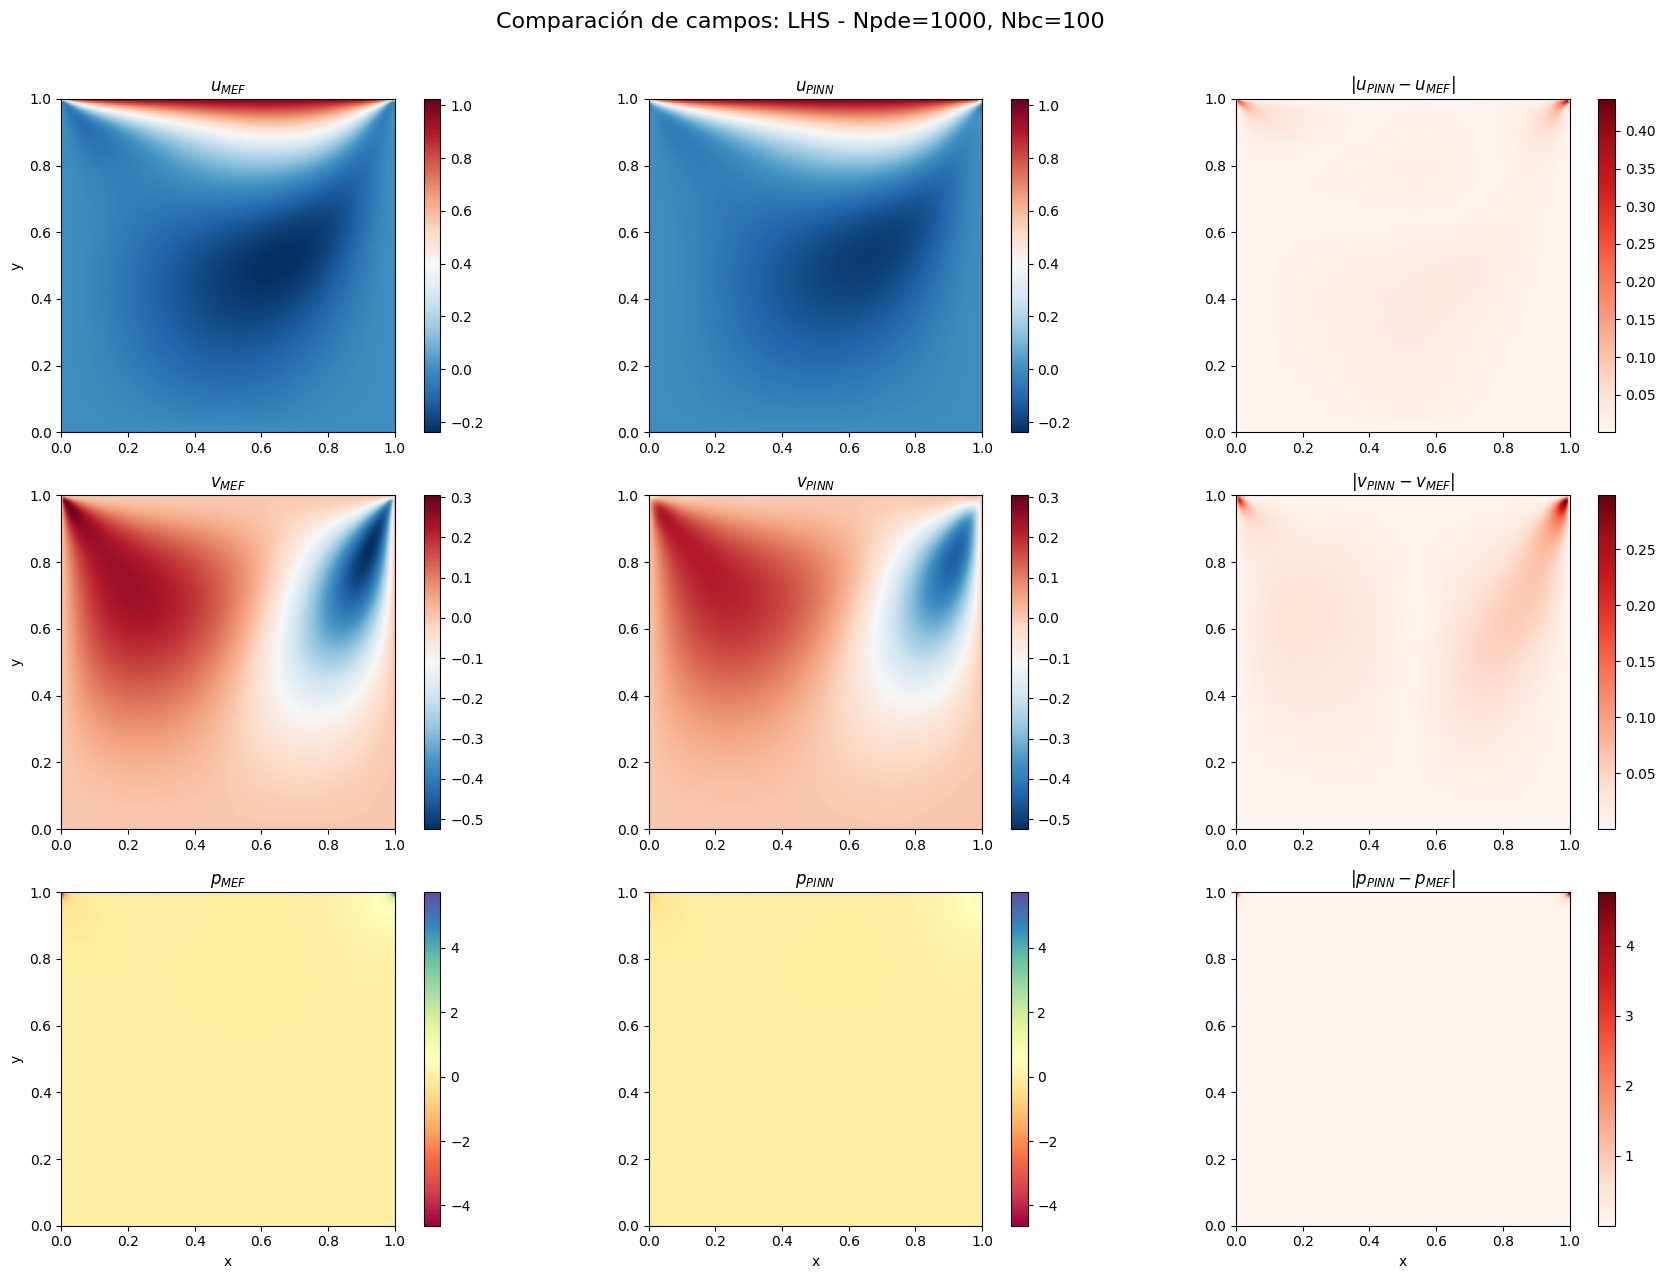


=== Entrenando modelo: lhs_Npde10000_Nbc1000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:41, 45.04it/s]

Epoch    0 | Total: 9.39e+00 | PDE: 4.03e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2198 | u_top: 0.372


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:10<03:12, 49.24it/s]

Epoch  500 | Total: 3.21e-01 | PDE: 5.21e-02 | BC: 2.69e-02 | P_ref: 3.14e-06 | p(0,0): -0.0014 | u_top: 0.985


Entrenando modelo PINN:  10%|█         | 1006/10000 [00:20<03:04, 48.86it/s]

Epoch 1000 | Total: 1.89e-01 | PDE: 3.78e-02 | BC: 1.51e-02 | P_ref: 2.91e-07 | p(0,0): -0.0008 | u_top: 0.971


Entrenando modelo PINN:  15%|█▌        | 1507/10000 [00:30<02:54, 48.80it/s]

Epoch 1500 | Total: 1.24e-01 | PDE: 2.03e-02 | BC: 1.04e-02 | P_ref: 7.84e-06 | p(0,0): 0.0017 | u_top: 0.982


Entrenando modelo PINN:  20%|██        | 2006/10000 [00:41<02:44, 48.70it/s]

Epoch 2000 | Total: 9.36e-02 | PDE: 1.31e-02 | BC: 8.05e-03 | P_ref: 4.30e-06 | p(0,0): 0.0026 | u_top: 0.979


Entrenando modelo PINN:  25%|██▌       | 2509/10000 [00:51<02:33, 48.76it/s]

Epoch 2500 | Total: 8.15e-02 | PDE: 1.11e-02 | BC: 7.04e-03 | P_ref: 6.06e-06 | p(0,0): -0.0017 | u_top: 0.998


Entrenando modelo PINN:  30%|███       | 3008/10000 [01:01<02:23, 48.75it/s]

Epoch 3000 | Total: 6.31e-02 | PDE: 8.29e-03 | BC: 5.49e-03 | P_ref: 1.06e-07 | p(0,0): 0.0003 | u_top: 0.997


Entrenando modelo PINN:  35%|███▌      | 3507/10000 [01:11<02:12, 49.04it/s]

Epoch 3500 | Total: 5.49e-02 | PDE: 7.84e-03 | BC: 4.71e-03 | P_ref: 5.53e-08 | p(0,0): 0.0003 | u_top: 0.994


Entrenando modelo PINN:  40%|████      | 4010/10000 [01:22<02:03, 48.70it/s]

Epoch 4000 | Total: 5.07e-02 | PDE: 7.90e-03 | BC: 4.28e-03 | P_ref: 2.91e-07 | p(0,0): -0.0007 | u_top: 0.988


Entrenando modelo PINN:  45%|████▌     | 4506/10000 [01:32<01:53, 48.45it/s]

Epoch 4500 | Total: 4.26e-02 | PDE: 6.84e-03 | BC: 3.57e-03 | P_ref: 5.13e-09 | p(0,0): 0.0001 | u_top: 0.994


Entrenando modelo PINN:  50%|█████     | 5010/10000 [01:42<01:42, 48.54it/s]

Epoch 5000 | Total: 4.00e-02 | PDE: 7.05e-03 | BC: 3.30e-03 | P_ref: 1.50e-08 | p(0,0): 0.0000 | u_top: 0.989


Entrenando modelo PINN:  55%|█████▌    | 5507/10000 [01:52<01:31, 49.05it/s]

Epoch 5500 | Total: 3.36e-02 | PDE: 5.65e-03 | BC: 2.80e-03 | P_ref: 3.26e-09 | p(0,0): 0.0000 | u_top: 0.995


Entrenando modelo PINN:  60%|██████    | 6009/10000 [02:02<01:20, 49.85it/s]

Epoch 6000 | Total: 3.03e-02 | PDE: 5.15e-03 | BC: 2.52e-03 | P_ref: 1.11e-11 | p(0,0): 0.0002 | u_top: 0.998


Entrenando modelo PINN:  65%|██████▌   | 6510/10000 [02:13<01:11, 48.63it/s]

Epoch 6500 | Total: 2.75e-02 | PDE: 4.78e-03 | BC: 2.27e-03 | P_ref: 1.10e-08 | p(0,0): -0.0001 | u_top: 0.997


Entrenando modelo PINN:  70%|███████   | 7007/10000 [02:23<01:00, 49.13it/s]

Epoch 7000 | Total: 2.53e-02 | PDE: 4.50e-03 | BC: 2.08e-03 | P_ref: 4.74e-09 | p(0,0): 0.0001 | u_top: 0.999


Entrenando modelo PINN:  75%|███████▌  | 7509/10000 [02:33<00:52, 47.70it/s]

Epoch 7500 | Total: 2.34e-02 | PDE: 4.30e-03 | BC: 1.91e-03 | P_ref: 4.05e-10 | p(0,0): 0.0001 | u_top: 0.999


Entrenando modelo PINN:  80%|████████  | 8010/10000 [02:44<00:41, 48.30it/s]

Epoch 8000 | Total: 2.16e-02 | PDE: 3.91e-03 | BC: 1.76e-03 | P_ref: 3.67e-09 | p(0,0): -0.0000 | u_top: 0.999


Entrenando modelo PINN:  85%|████████▌ | 8506/10000 [02:54<00:31, 47.00it/s]

Epoch 8500 | Total: 1.99e-02 | PDE: 3.66e-03 | BC: 1.62e-03 | P_ref: 5.31e-09 | p(0,0): 0.0000 | u_top: 0.998


Entrenando modelo PINN:  90%|█████████ | 9008/10000 [03:04<00:21, 46.99it/s]

Epoch 9000 | Total: 1.86e-02 | PDE: 3.44e-03 | BC: 1.51e-03 | P_ref: 5.17e-09 | p(0,0): -0.0000 | u_top: 0.998


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [03:14<00:10, 45.38it/s]

Epoch 9500 | Total: 1.74e-02 | PDE: 3.24e-03 | BC: 1.42e-03 | P_ref: 6.34e-10 | p(0,0): 0.0000 | u_top: 0.998


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:23<00:00, 49.07it/s]


Epoch 9999 | Total: 1.64e-02 | PDE: 3.02e-03 | BC: 1.33e-03 | P_ref: 3.95e-10 | p(0,0): 0.0000 | u_top: 0.998

Tiempo total: 203.8 segundos
Modelo guardado como: models/pinn_lhs_Npde10000_Nbc1000_20250729_182207.pt
Plotting training losses for lhs_Npde10000_Nbc1000


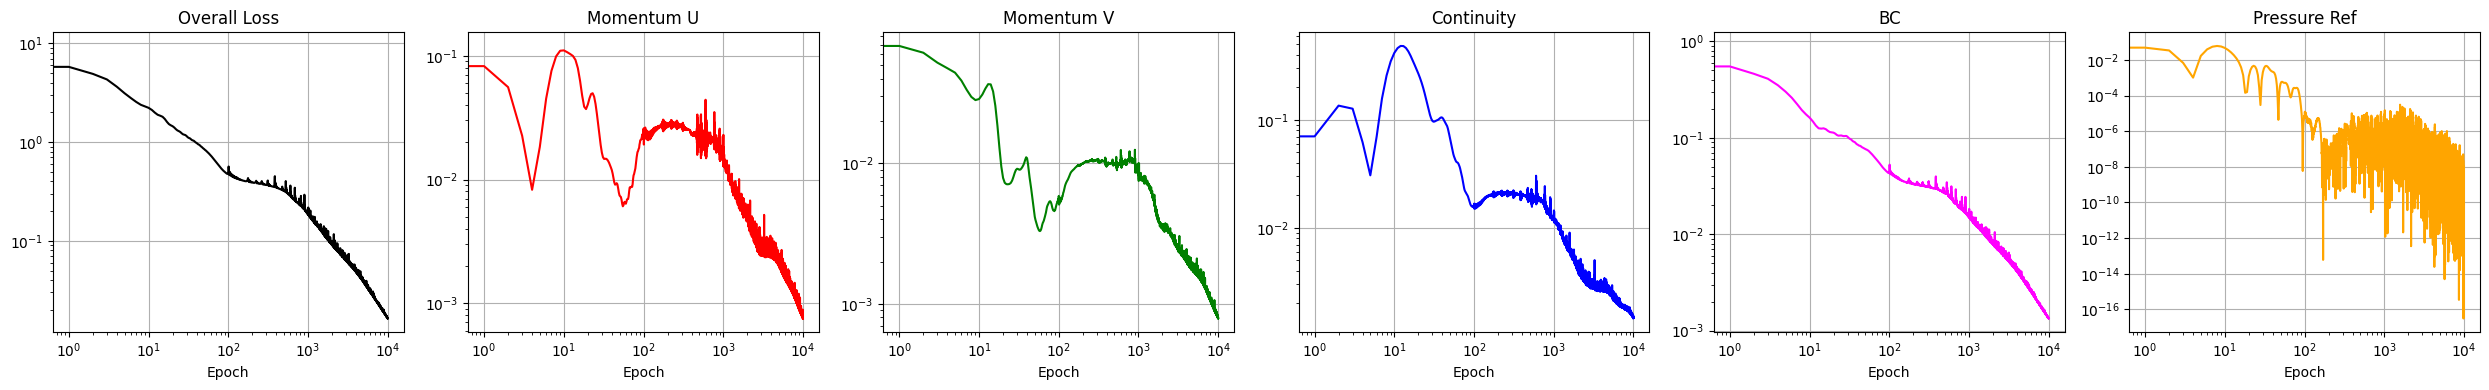

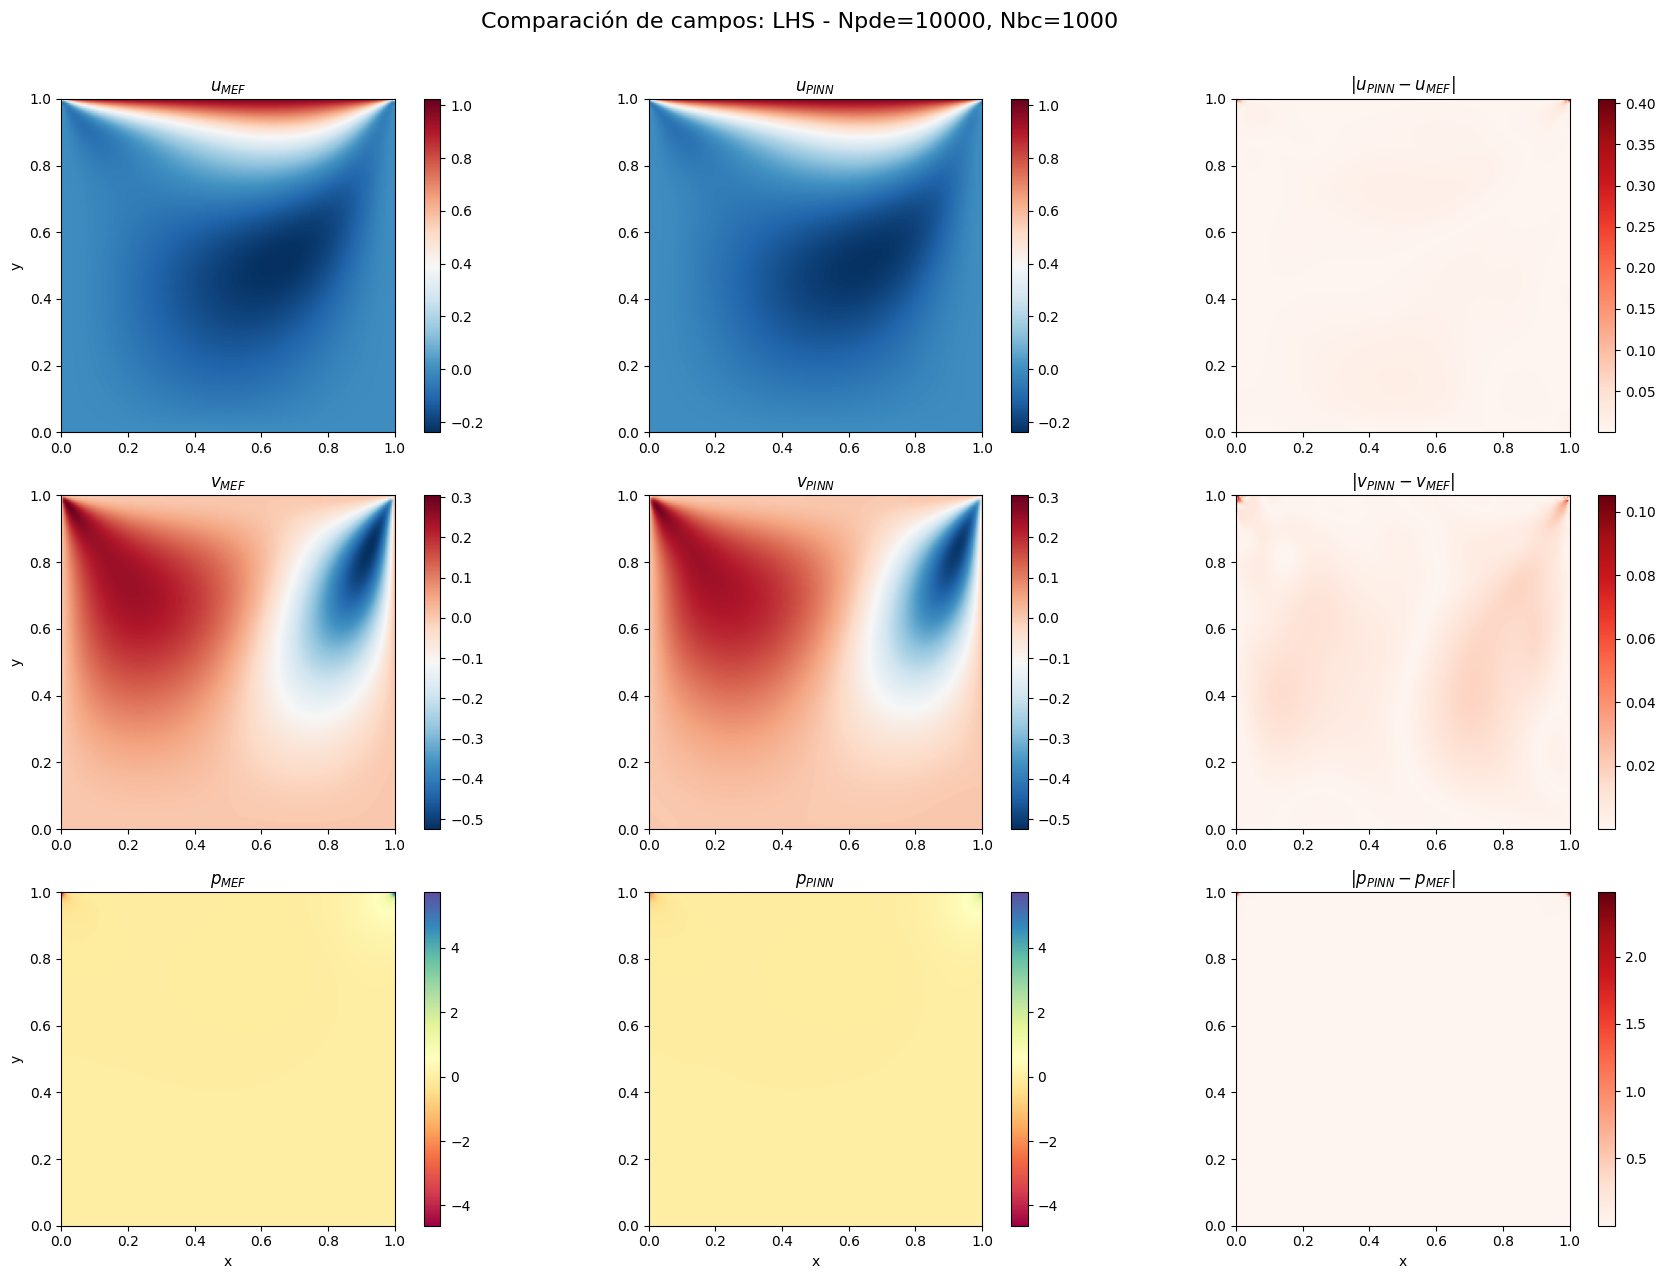


=== Entrenando modelo: lhs_Npde100000_Nbc10000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<18:29,  9.02it/s]

Epoch    0 | Total: 9.39e+00 | PDE: 4.05e-01 | BC: 8.96e-01 | P_ref: 2.25e-02 | p(0,0): 0.2202 | u_top: 0.372


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:56<18:09,  8.72it/s]

Epoch  500 | Total: 3.19e-01 | PDE: 5.07e-02 | BC: 2.68e-02 | P_ref: 2.01e-06 | p(0,0): -0.0008 | u_top: 0.980


Entrenando modelo PINN:  10%|█         | 1002/10000 [01:52<16:41,  8.99it/s]

Epoch 1000 | Total: 1.86e-01 | PDE: 3.40e-02 | BC: 1.52e-02 | P_ref: 3.43e-08 | p(0,0): -0.0016 | u_top: 0.975


Entrenando modelo PINN:  15%|█▌        | 1502/10000 [02:47<15:48,  8.96it/s]

Epoch 1500 | Total: 1.56e-01 | PDE: 2.31e-02 | BC: 1.33e-02 | P_ref: 6.60e-07 | p(0,0): -0.0012 | u_top: 0.938


Entrenando modelo PINN:  20%|██        | 2002/10000 [03:43<14:46,  9.02it/s]

Epoch 2000 | Total: 1.02e-01 | PDE: 1.39e-02 | BC: 8.79e-03 | P_ref: 8.13e-08 | p(0,0): 0.0002 | u_top: 0.982


Entrenando modelo PINN:  25%|██▌       | 2502/10000 [04:39<14:01,  8.91it/s]

Epoch 2500 | Total: 8.20e-02 | PDE: 1.04e-02 | BC: 7.16e-03 | P_ref: 1.26e-06 | p(0,0): -0.0011 | u_top: 0.988


Entrenando modelo PINN:  30%|███       | 3002/10000 [05:36<13:08,  8.88it/s]

Epoch 3000 | Total: 7.24e-02 | PDE: 9.02e-03 | BC: 6.34e-03 | P_ref: 2.67e-07 | p(0,0): 0.0008 | u_top: 0.991


Entrenando modelo PINN:  35%|███▌      | 3502/10000 [06:32<12:14,  8.84it/s]

Epoch 3500 | Total: 6.63e-02 | PDE: 8.36e-03 | BC: 5.79e-03 | P_ref: 3.58e-07 | p(0,0): 0.0017 | u_top: 0.989


Entrenando modelo PINN:  40%|████      | 4002/10000 [07:29<11:16,  8.87it/s]

Epoch 4000 | Total: 5.94e-02 | PDE: 7.25e-03 | BC: 5.21e-03 | P_ref: 4.63e-08 | p(0,0): -0.0001 | u_top: 0.993


Entrenando modelo PINN:  45%|████▌     | 4502/10000 [08:25<10:22,  8.83it/s]

Epoch 4500 | Total: 5.52e-02 | PDE: 6.60e-03 | BC: 4.86e-03 | P_ref: 1.08e-07 | p(0,0): -0.0002 | u_top: 0.994


Entrenando modelo PINN:  50%|█████     | 5002/10000 [09:22<09:17,  8.97it/s]

Epoch 5000 | Total: 5.27e-02 | PDE: 6.09e-03 | BC: 4.66e-03 | P_ref: 2.11e-08 | p(0,0): -0.0003 | u_top: 1.002


Entrenando modelo PINN:  55%|█████▌    | 5502/10000 [10:18<08:21,  8.98it/s]

Epoch 5500 | Total: 4.90e-02 | PDE: 5.77e-03 | BC: 4.32e-03 | P_ref: 1.36e-10 | p(0,0): -0.0002 | u_top: 0.994


Entrenando modelo PINN:  60%|██████    | 6002/10000 [11:14<07:28,  8.92it/s]

Epoch 6000 | Total: 4.60e-02 | PDE: 5.34e-03 | BC: 4.06e-03 | P_ref: 1.95e-09 | p(0,0): -0.0003 | u_top: 0.993


Entrenando modelo PINN:  65%|██████▌   | 6502/10000 [12:11<06:33,  8.88it/s]

Epoch 6500 | Total: 4.47e-02 | PDE: 5.35e-03 | BC: 3.94e-03 | P_ref: 7.57e-08 | p(0,0): 0.0002 | u_top: 0.988


Entrenando modelo PINN:  70%|███████   | 7002/10000 [13:07<05:40,  8.81it/s]

Epoch 7000 | Total: 4.12e-02 | PDE: 4.57e-03 | BC: 3.66e-03 | P_ref: 3.24e-08 | p(0,0): -0.0002 | u_top: 0.996


Entrenando modelo PINN:  75%|███████▌  | 7502/10000 [14:03<04:41,  8.86it/s]

Epoch 7500 | Total: 4.11e-02 | PDE: 4.48e-03 | BC: 3.66e-03 | P_ref: 1.61e-08 | p(0,0): -0.0002 | u_top: 1.003


Entrenando modelo PINN:  80%|████████  | 8002/10000 [15:00<03:45,  8.88it/s]

Epoch 8000 | Total: 3.78e-02 | PDE: 4.21e-03 | BC: 3.36e-03 | P_ref: 6.84e-12 | p(0,0): -0.0001 | u_top: 0.997


Entrenando modelo PINN:  85%|████████▌ | 8502/10000 [15:56<02:48,  8.87it/s]

Epoch 8500 | Total: 3.65e-02 | PDE: 4.20e-03 | BC: 3.23e-03 | P_ref: 6.70e-09 | p(0,0): 0.0000 | u_top: 0.996


Entrenando modelo PINN:  90%|█████████ | 9002/10000 [16:53<01:53,  8.83it/s]

Epoch 9000 | Total: 3.52e-02 | PDE: 4.03e-03 | BC: 3.11e-03 | P_ref: 3.61e-10 | p(0,0): -0.0000 | u_top: 0.996


Entrenando modelo PINN:  95%|█████████▌| 9502/10000 [17:49<00:55,  8.98it/s]

Epoch 9500 | Total: 3.42e-02 | PDE: 3.94e-03 | BC: 3.03e-03 | P_ref: 6.38e-11 | p(0,0): -0.0000 | u_top: 0.996


Entrenando modelo PINN: 100%|██████████| 10000/10000 [18:45<00:00,  8.88it/s]


Epoch 9999 | Total: 3.33e-02 | PDE: 3.83e-03 | BC: 2.95e-03 | P_ref: 1.27e-10 | p(0,0): -0.0000 | u_top: 0.997

Tiempo total: 1125.7 segundos
Modelo guardado como: models/pinn_lhs_Npde100000_Nbc10000_20250729_184056.pt
Plotting training losses for lhs_Npde100000_Nbc10000


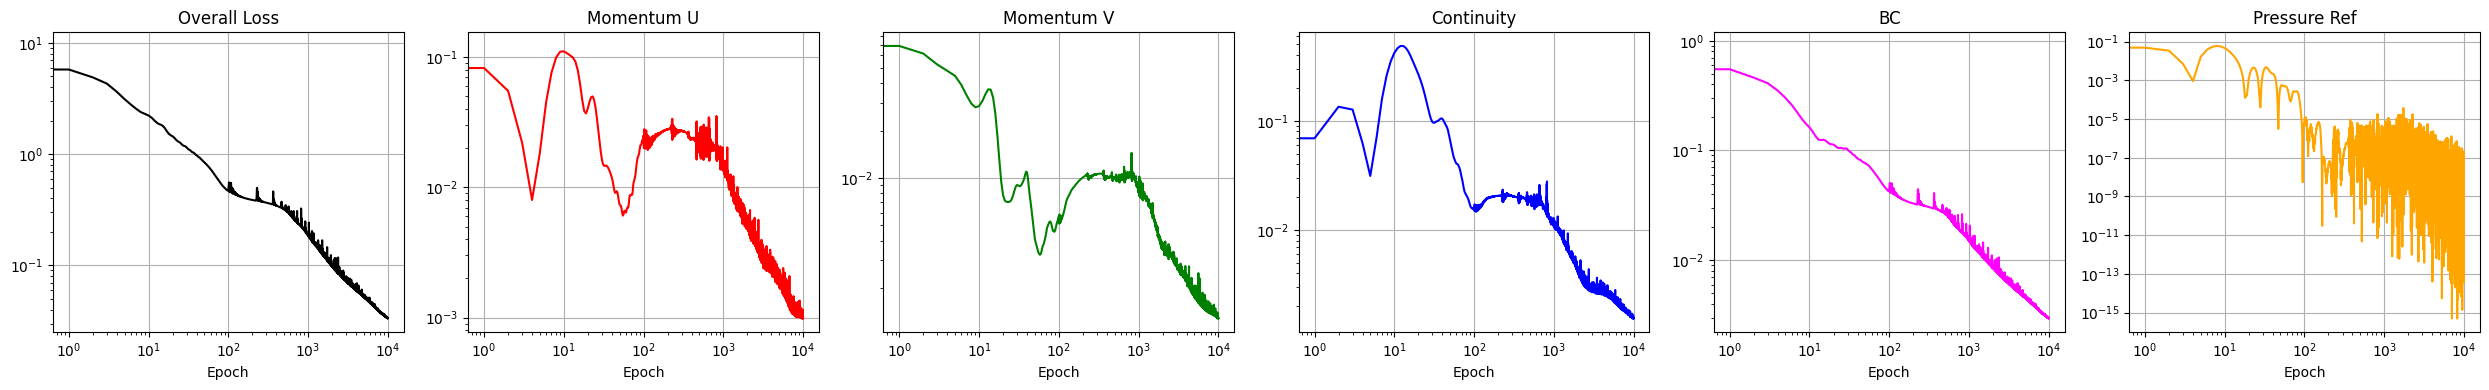

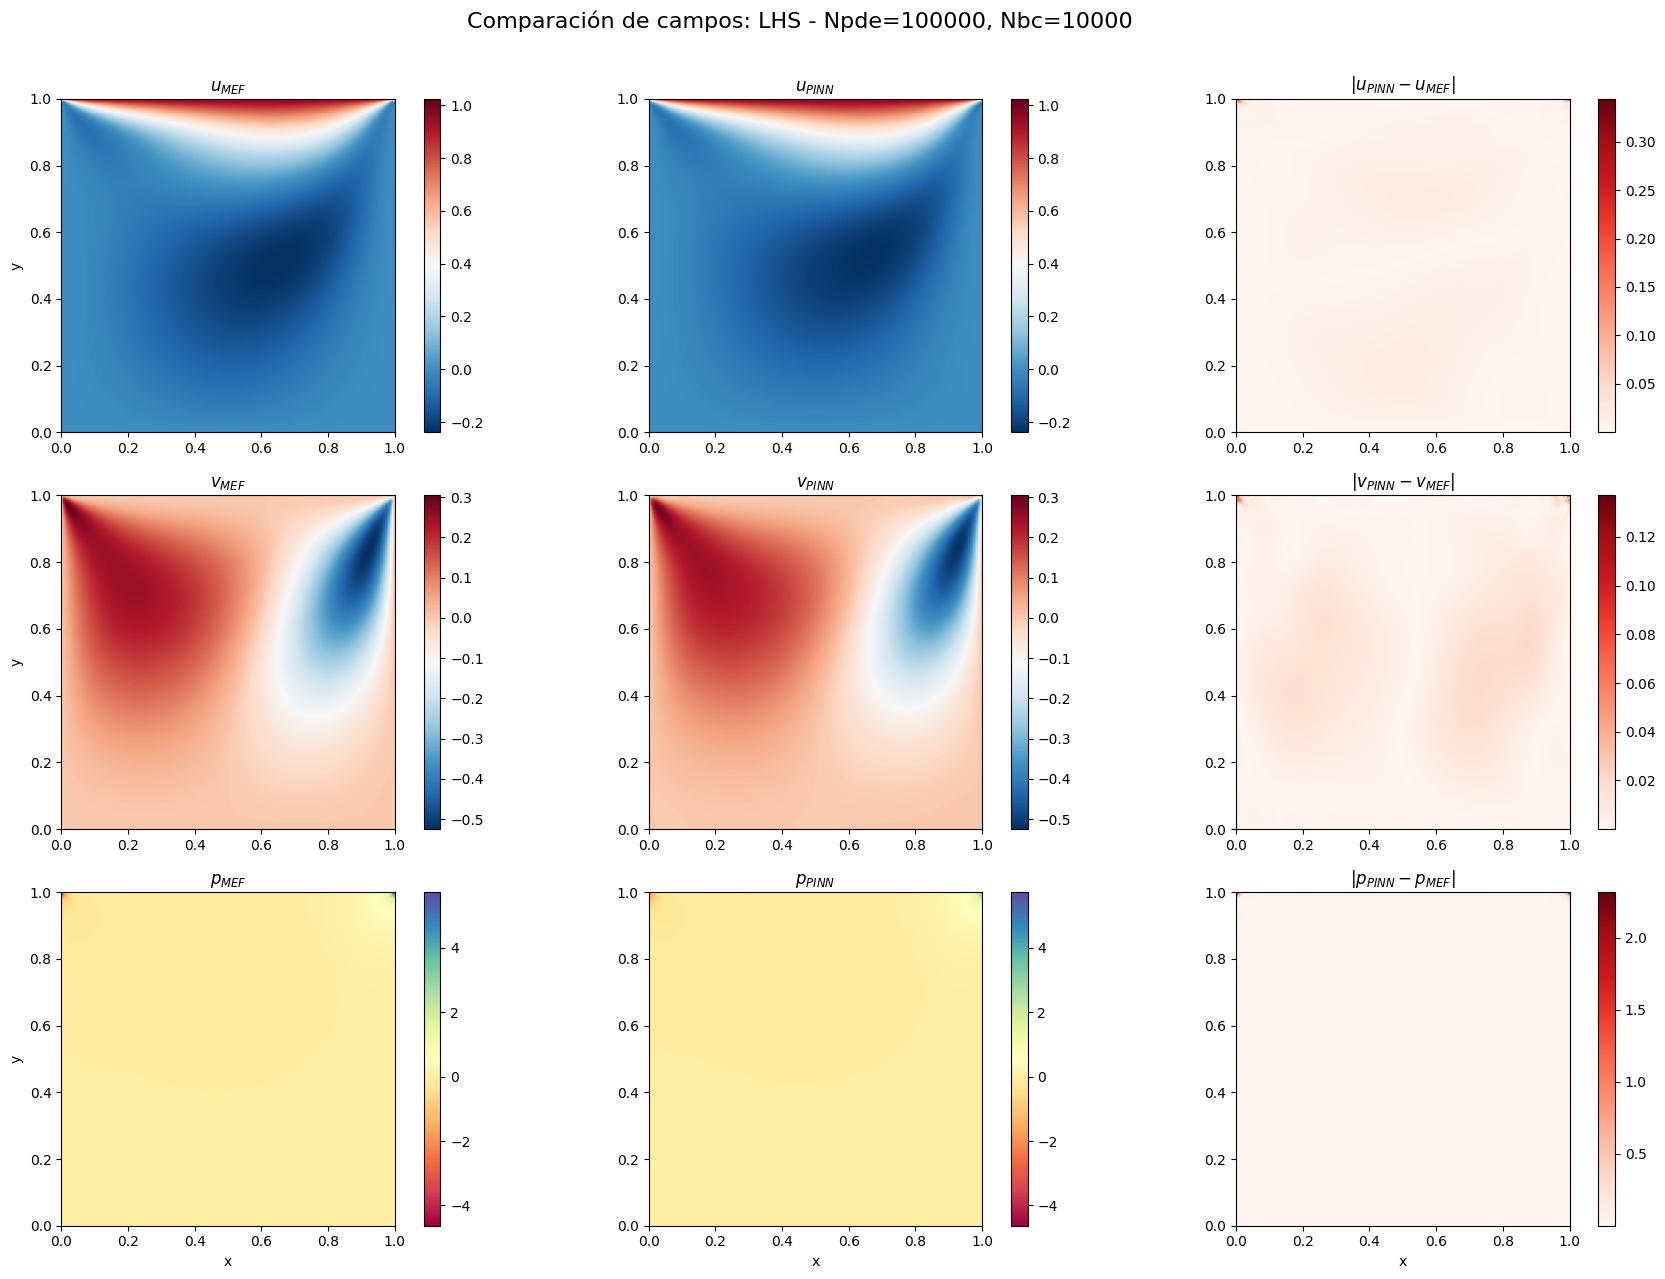


=== Entrenando modelo: rad_Npde1000_Nbc100 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:27, 48.16it/s]

Epoch    0 | Total: 1.06e+01 | PDE: 8.39e-01 | BC: 9.76e-01 | P_ref: 2.25e-02 | p(0,0): 0.1993 | u_top: 0.338


Entrenando modelo PINN:   5%|▌         | 510/10000 [00:10<03:11, 49.48it/s]

Epoch  500 | Total: 7.92e-01 | PDE: 8.30e-02 | BC: 7.09e-02 | P_ref: 1.52e-05 | p(0,0): 0.0025 | u_top: 0.926


Entrenando modelo PINN:  10%|█         | 1010/10000 [00:20<02:58, 50.31it/s]

Epoch 1000 | Total: 6.04e-01 | PDE: 1.01e-01 | BC: 5.04e-02 | P_ref: 1.01e-06 | p(0,0): -0.0159 | u_top: 0.962


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:30<02:49, 50.13it/s]

Epoch 1500 | Total: 3.90e-01 | PDE: 7.36e-02 | BC: 3.17e-02 | P_ref: 2.91e-05 | p(0,0): -0.0058 | u_top: 0.926


Entrenando modelo PINN:  20%|██        | 2007/10000 [00:40<02:40, 49.89it/s]

Epoch 2000 | Total: 2.64e-01 | PDE: 2.97e-02 | BC: 2.34e-02 | P_ref: 5.97e-07 | p(0,0): 0.0016 | u_top: 0.983


Entrenando modelo PINN:  25%|██▌       | 2506/10000 [00:50<02:30, 49.87it/s]

Epoch 2500 | Total: 2.40e-01 | PDE: 3.34e-02 | BC: 2.07e-02 | P_ref: 2.20e-05 | p(0,0): 0.0056 | u_top: 1.003


Entrenando modelo PINN:  30%|███       | 3010/10000 [01:00<02:21, 49.26it/s]

Epoch 3000 | Total: 1.86e-01 | PDE: 1.99e-02 | BC: 1.66e-02 | P_ref: 4.58e-07 | p(0,0): 0.0002 | u_top: 0.982


Entrenando modelo PINN:  35%|███▌      | 3509/10000 [01:10<02:11, 49.48it/s]

Epoch 3500 | Total: 1.62e-01 | PDE: 1.84e-02 | BC: 1.44e-02 | P_ref: 7.34e-07 | p(0,0): 0.0007 | u_top: 0.986


Entrenando modelo PINN:  40%|████      | 4010/10000 [01:21<02:02, 48.99it/s]

Epoch 4000 | Total: 1.48e-01 | PDE: 2.33e-02 | BC: 1.25e-02 | P_ref: 1.85e-07 | p(0,0): -0.0006 | u_top: 0.981


Entrenando modelo PINN:  45%|████▌     | 4507/10000 [01:31<01:52, 48.85it/s]

Epoch 4500 | Total: 1.26e-01 | PDE: 2.33e-02 | BC: 1.03e-02 | P_ref: 2.26e-09 | p(0,0): -0.0009 | u_top: 0.987


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:41<01:41, 48.95it/s]

Epoch 5000 | Total: 1.04e-01 | PDE: 1.74e-02 | BC: 8.61e-03 | P_ref: 3.48e-08 | p(0,0): -0.0001 | u_top: 0.992


Entrenando modelo PINN:  55%|█████▌    | 5507/10000 [01:51<01:31, 49.03it/s]

Epoch 5500 | Total: 8.83e-02 | PDE: 1.51e-02 | BC: 7.32e-03 | P_ref: 8.17e-07 | p(0,0): 0.0008 | u_top: 0.994


Entrenando modelo PINN:  60%|██████    | 6006/10000 [02:01<01:20, 49.48it/s]

Epoch 6000 | Total: 7.89e-02 | PDE: 1.37e-02 | BC: 6.52e-03 | P_ref: 1.16e-06 | p(0,0): -0.0015 | u_top: 0.983


Entrenando modelo PINN:  65%|██████▌   | 6509/10000 [02:11<01:10, 49.23it/s]

Epoch 6500 | Total: 6.87e-02 | PDE: 1.13e-02 | BC: 5.74e-03 | P_ref: 4.61e-08 | p(0,0): -0.0005 | u_top: 0.991


Entrenando modelo PINN:  70%|███████   | 7009/10000 [02:21<00:59, 50.11it/s]

Epoch 7000 | Total: 6.30e-02 | PDE: 9.71e-03 | BC: 5.33e-03 | P_ref: 1.14e-07 | p(0,0): -0.0004 | u_top: 0.990


Entrenando modelo PINN:  75%|███████▌  | 7508/10000 [02:31<00:51, 48.57it/s]

Epoch 7500 | Total: 5.92e-02 | PDE: 9.21e-03 | BC: 5.00e-03 | P_ref: 1.75e-08 | p(0,0): 0.0002 | u_top: 0.994


Entrenando modelo PINN:  80%|████████  | 8006/10000 [02:41<00:41, 48.13it/s]

Epoch 8000 | Total: 5.63e-02 | PDE: 8.52e-03 | BC: 4.78e-03 | P_ref: 7.23e-07 | p(0,0): -0.0010 | u_top: 0.990


Entrenando modelo PINN:  85%|████████▌ | 8509/10000 [02:52<00:31, 47.82it/s]

Epoch 8500 | Total: 5.28e-02 | PDE: 7.63e-03 | BC: 4.51e-03 | P_ref: 3.68e-08 | p(0,0): 0.0001 | u_top: 0.994


Entrenando modelo PINN:  90%|█████████ | 9006/10000 [03:01<00:18, 52.35it/s]

Epoch 9000 | Total: 5.07e-02 | PDE: 7.81e-03 | BC: 4.29e-03 | P_ref: 7.46e-09 | p(0,0): -0.0001 | u_top: 0.995


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [03:11<00:09, 52.59it/s]

Epoch 9500 | Total: 4.79e-02 | PDE: 6.80e-03 | BC: 4.11e-03 | P_ref: 4.66e-07 | p(0,0): 0.0007 | u_top: 0.996


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:20<00:00, 49.83it/s]


Epoch 9999 | Total: 4.51e-02 | PDE: 6.00e-03 | BC: 3.91e-03 | P_ref: 4.45e-08 | p(0,0): 0.0002 | u_top: 0.995

Tiempo total: 200.7 segundos
Modelo guardado como: models/pinn_rad_Npde1000_Nbc100_20250729_184421.pt
Plotting training losses for rad_Npde1000_Nbc100


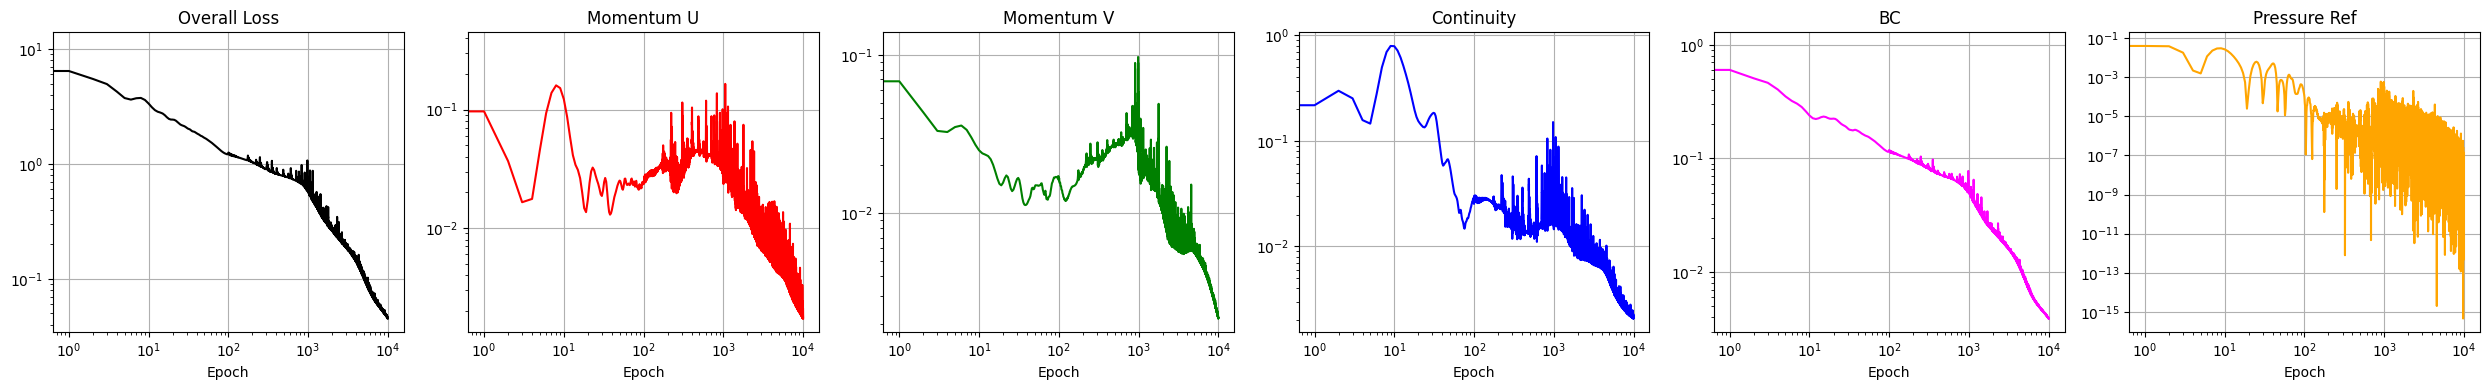

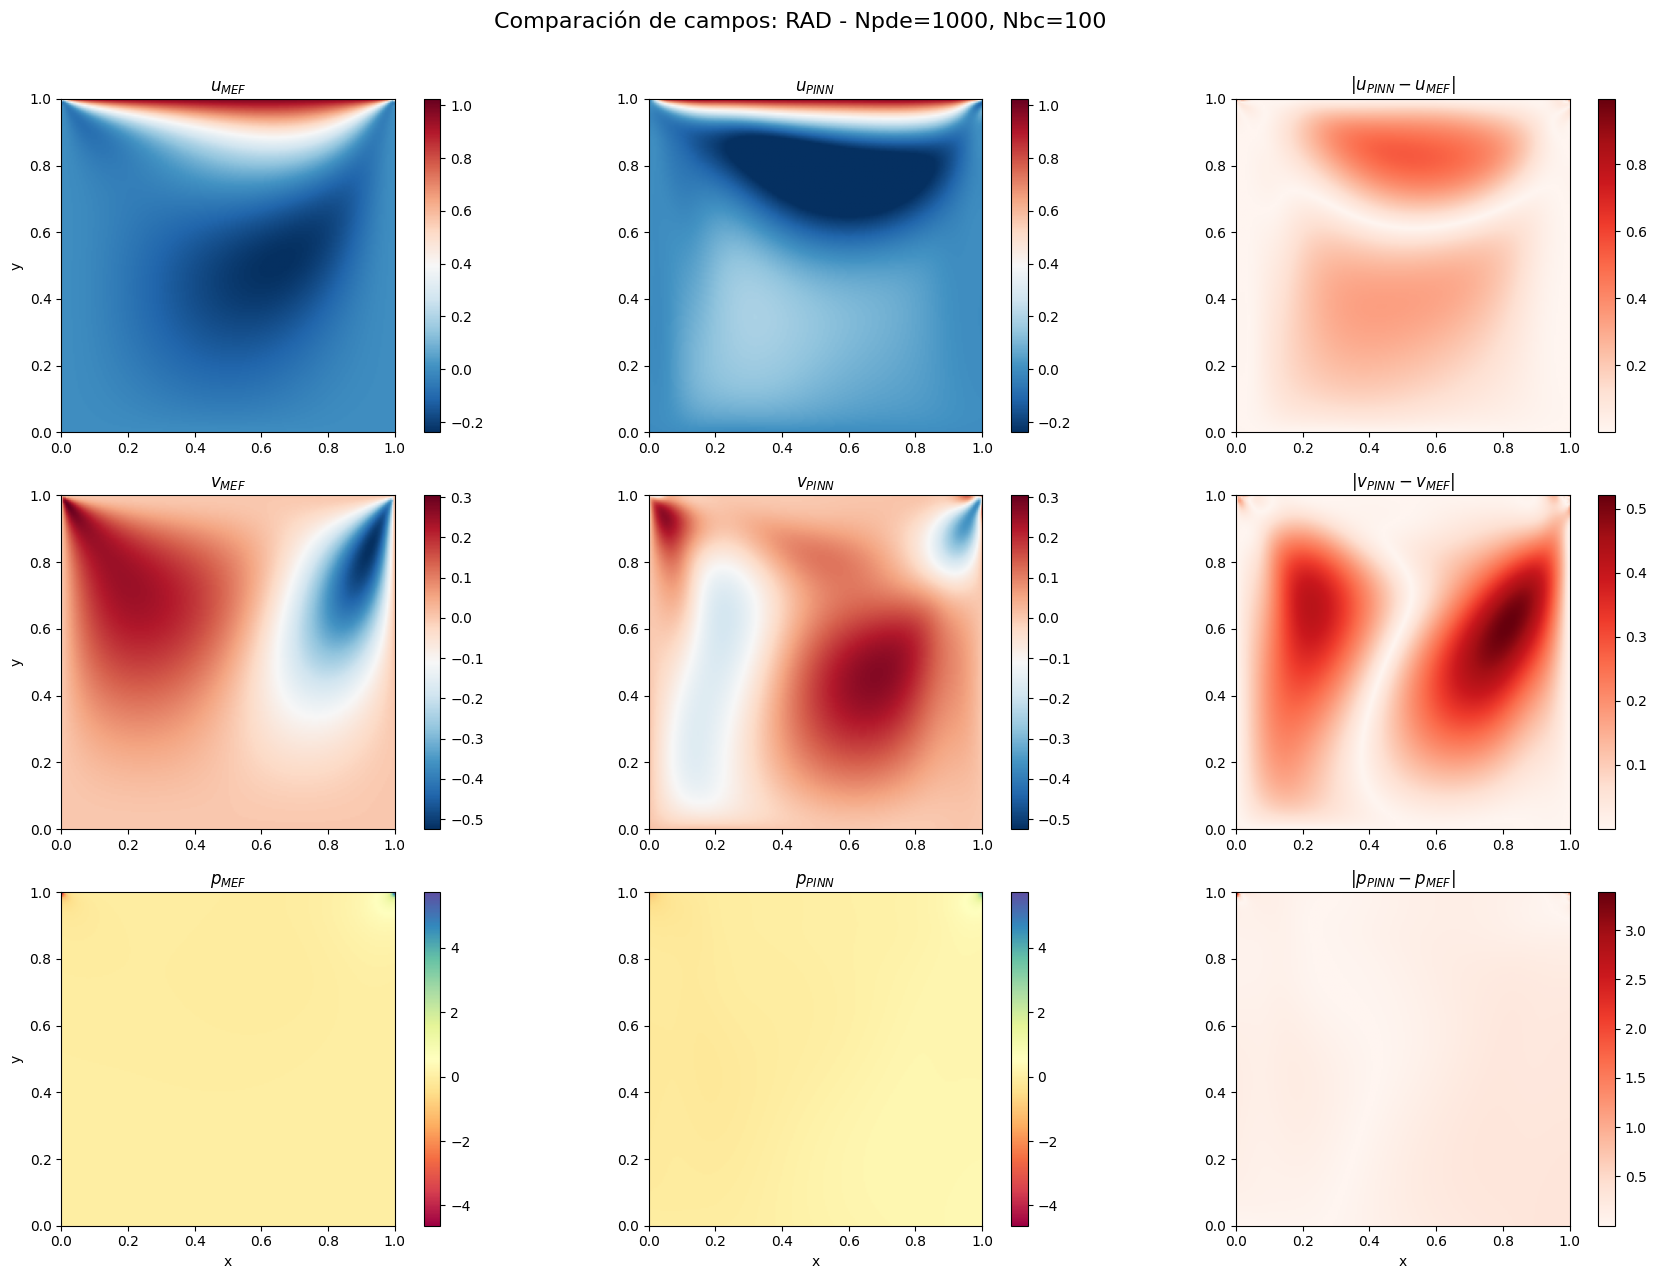


=== Entrenando modelo: rad_Npde10000_Nbc1000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 5/10000 [00:00<03:46, 44.15it/s]

Epoch    0 | Total: 9.38e+00 | PDE: 5.48e-01 | BC: 8.81e-01 | P_ref: 2.25e-02 | p(0,0): 0.2141 | u_top: 0.373


Entrenando modelo PINN:   5%|▌         | 511/10000 [00:09<03:00, 52.66it/s]

Epoch  500 | Total: 4.29e-01 | PDE: 4.60e-02 | BC: 3.83e-02 | P_ref: 2.76e-06 | p(0,0): 0.0005 | u_top: 0.926


Entrenando modelo PINN:  10%|█         | 1009/10000 [00:19<02:51, 52.54it/s]

Epoch 1000 | Total: 2.75e-01 | PDE: 3.54e-02 | BC: 2.39e-02 | P_ref: 2.92e-06 | p(0,0): -0.0012 | u_top: 0.985


Entrenando modelo PINN:  15%|█▌        | 1508/10000 [00:29<03:05, 45.85it/s]

Epoch 1500 | Total: 2.10e-01 | PDE: 2.02e-02 | BC: 1.90e-02 | P_ref: 6.01e-07 | p(0,0): -0.0015 | u_top: 1.006


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:39<02:44, 48.46it/s]

Epoch 2000 | Total: 1.56e-01 | PDE: 1.75e-02 | BC: 1.38e-02 | P_ref: 7.50e-06 | p(0,0): -0.0021 | u_top: 0.983


Entrenando modelo PINN:  25%|██▌       | 2506/10000 [00:50<02:34, 48.56it/s]

Epoch 2500 | Total: 1.29e-01 | PDE: 1.11e-02 | BC: 1.18e-02 | P_ref: 1.56e-07 | p(0,0): -0.0008 | u_top: 0.979


Entrenando modelo PINN:  30%|███       | 3006/10000 [01:00<02:12, 52.67it/s]

Epoch 3000 | Total: 1.15e-01 | PDE: 1.01e-02 | BC: 1.05e-02 | P_ref: 1.72e-07 | p(0,0): -0.0005 | u_top: 0.984


Entrenando modelo PINN:  35%|███▌      | 3510/10000 [01:09<02:02, 53.00it/s]

Epoch 3500 | Total: 1.10e-01 | PDE: 1.23e-02 | BC: 9.73e-03 | P_ref: 8.42e-07 | p(0,0): -0.0016 | u_top: 0.981


Entrenando modelo PINN:  40%|████      | 4008/10000 [01:19<01:52, 53.17it/s]

Epoch 4000 | Total: 9.64e-02 | PDE: 9.18e-03 | BC: 8.72e-03 | P_ref: 2.71e-06 | p(0,0): 0.0013 | u_top: 0.995


Entrenando modelo PINN:  45%|████▌     | 4506/10000 [01:28<01:47, 51.25it/s]

Epoch 4500 | Total: 8.74e-02 | PDE: 8.98e-03 | BC: 7.84e-03 | P_ref: 1.77e-07 | p(0,0): -0.0008 | u_top: 0.984


Entrenando modelo PINN:  50%|█████     | 5007/10000 [01:39<01:46, 46.81it/s]

Epoch 5000 | Total: 7.97e-02 | PDE: 9.04e-03 | BC: 7.07e-03 | P_ref: 2.27e-08 | p(0,0): -0.0001 | u_top: 0.984


Entrenando modelo PINN:  55%|█████▌    | 5510/10000 [01:49<01:32, 48.65it/s]

Epoch 5500 | Total: 7.11e-02 | PDE: 8.34e-03 | BC: 6.28e-03 | P_ref: 2.47e-08 | p(0,0): 0.0002 | u_top: 0.994


Entrenando modelo PINN:  60%|██████    | 6007/10000 [02:00<01:21, 48.89it/s]

Epoch 6000 | Total: 6.58e-02 | PDE: 8.10e-03 | BC: 5.77e-03 | P_ref: 1.51e-07 | p(0,0): 0.0002 | u_top: 0.999


Entrenando modelo PINN:  65%|██████▌   | 6506/10000 [02:10<01:12, 48.39it/s]

Epoch 6500 | Total: 5.97e-02 | PDE: 8.63e-03 | BC: 5.10e-03 | P_ref: 2.47e-06 | p(0,0): -0.0019 | u_top: 0.990


Entrenando modelo PINN:  70%|███████   | 7007/10000 [02:20<01:00, 49.35it/s]

Epoch 7000 | Total: 5.41e-02 | PDE: 8.05e-03 | BC: 4.60e-03 | P_ref: 2.35e-08 | p(0,0): 0.0001 | u_top: 0.992


Entrenando modelo PINN:  75%|███████▌  | 7510/10000 [02:30<00:50, 48.98it/s]

Epoch 7500 | Total: 4.96e-02 | PDE: 7.75e-03 | BC: 4.18e-03 | P_ref: 5.23e-09 | p(0,0): -0.0001 | u_top: 0.995


Entrenando modelo PINN:  80%|████████  | 8009/10000 [02:41<00:40, 48.63it/s]

Epoch 8000 | Total: 4.60e-02 | PDE: 7.63e-03 | BC: 3.84e-03 | P_ref: 2.75e-07 | p(0,0): -0.0008 | u_top: 0.995


Entrenando modelo PINN:  85%|████████▌ | 8507/10000 [02:51<00:30, 49.01it/s]

Epoch 8500 | Total: 4.26e-02 | PDE: 7.18e-03 | BC: 3.54e-03 | P_ref: 6.61e-09 | p(0,0): -0.0002 | u_top: 0.995


Entrenando modelo PINN:  90%|█████████ | 9010/10000 [03:01<00:20, 48.42it/s]

Epoch 9000 | Total: 3.98e-02 | PDE: 6.81e-03 | BC: 3.30e-03 | P_ref: 2.59e-09 | p(0,0): -0.0002 | u_top: 0.996


Entrenando modelo PINN:  95%|█████████▌| 9508/10000 [03:11<00:10, 49.07it/s]

Epoch 9500 | Total: 3.73e-02 | PDE: 6.50e-03 | BC: 3.08e-03 | P_ref: 2.40e-08 | p(0,0): -0.0001 | u_top: 0.995


Entrenando modelo PINN: 100%|██████████| 10000/10000 [03:21<00:00, 49.51it/s]


Epoch 9999 | Total: 3.50e-02 | PDE: 6.17e-03 | BC: 2.89e-03 | P_ref: 2.99e-08 | p(0,0): 0.0000 | u_top: 0.996

Tiempo total: 202.0 segundos
Modelo guardado como: models/pinn_rad_Npde10000_Nbc1000_20250729_184747.pt
Plotting training losses for rad_Npde10000_Nbc1000


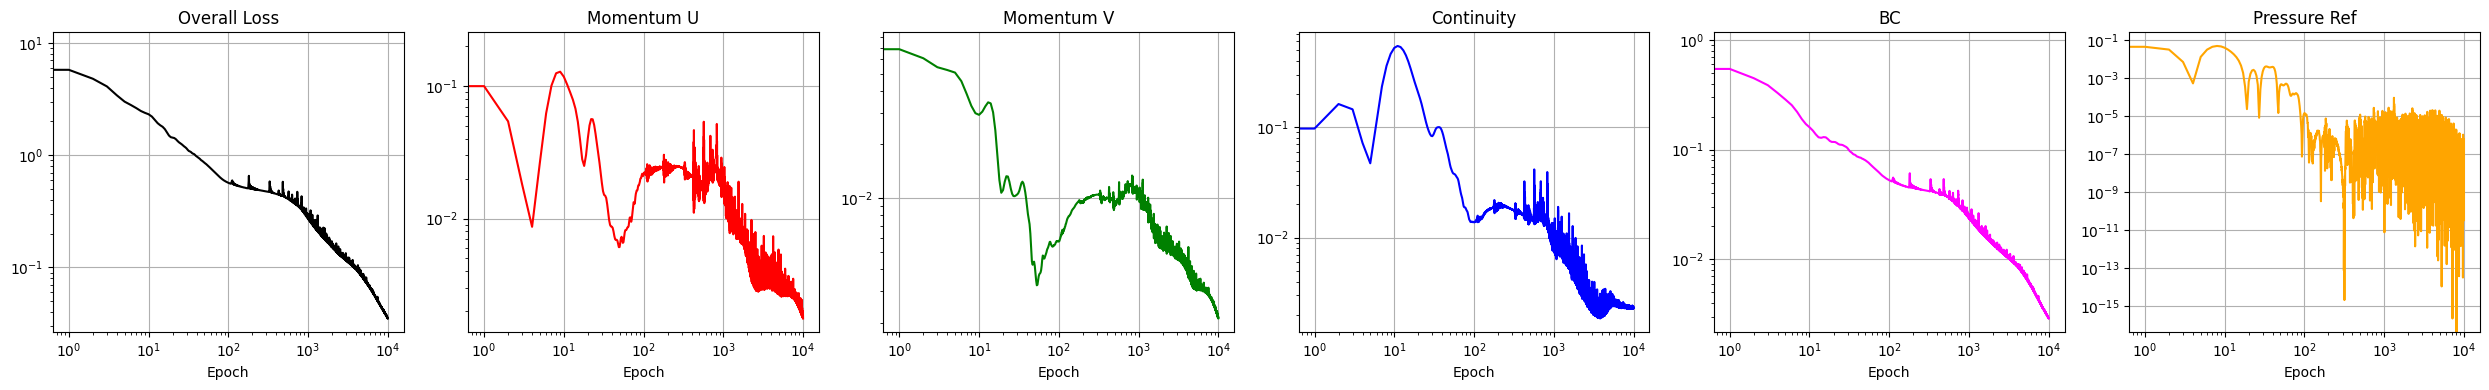

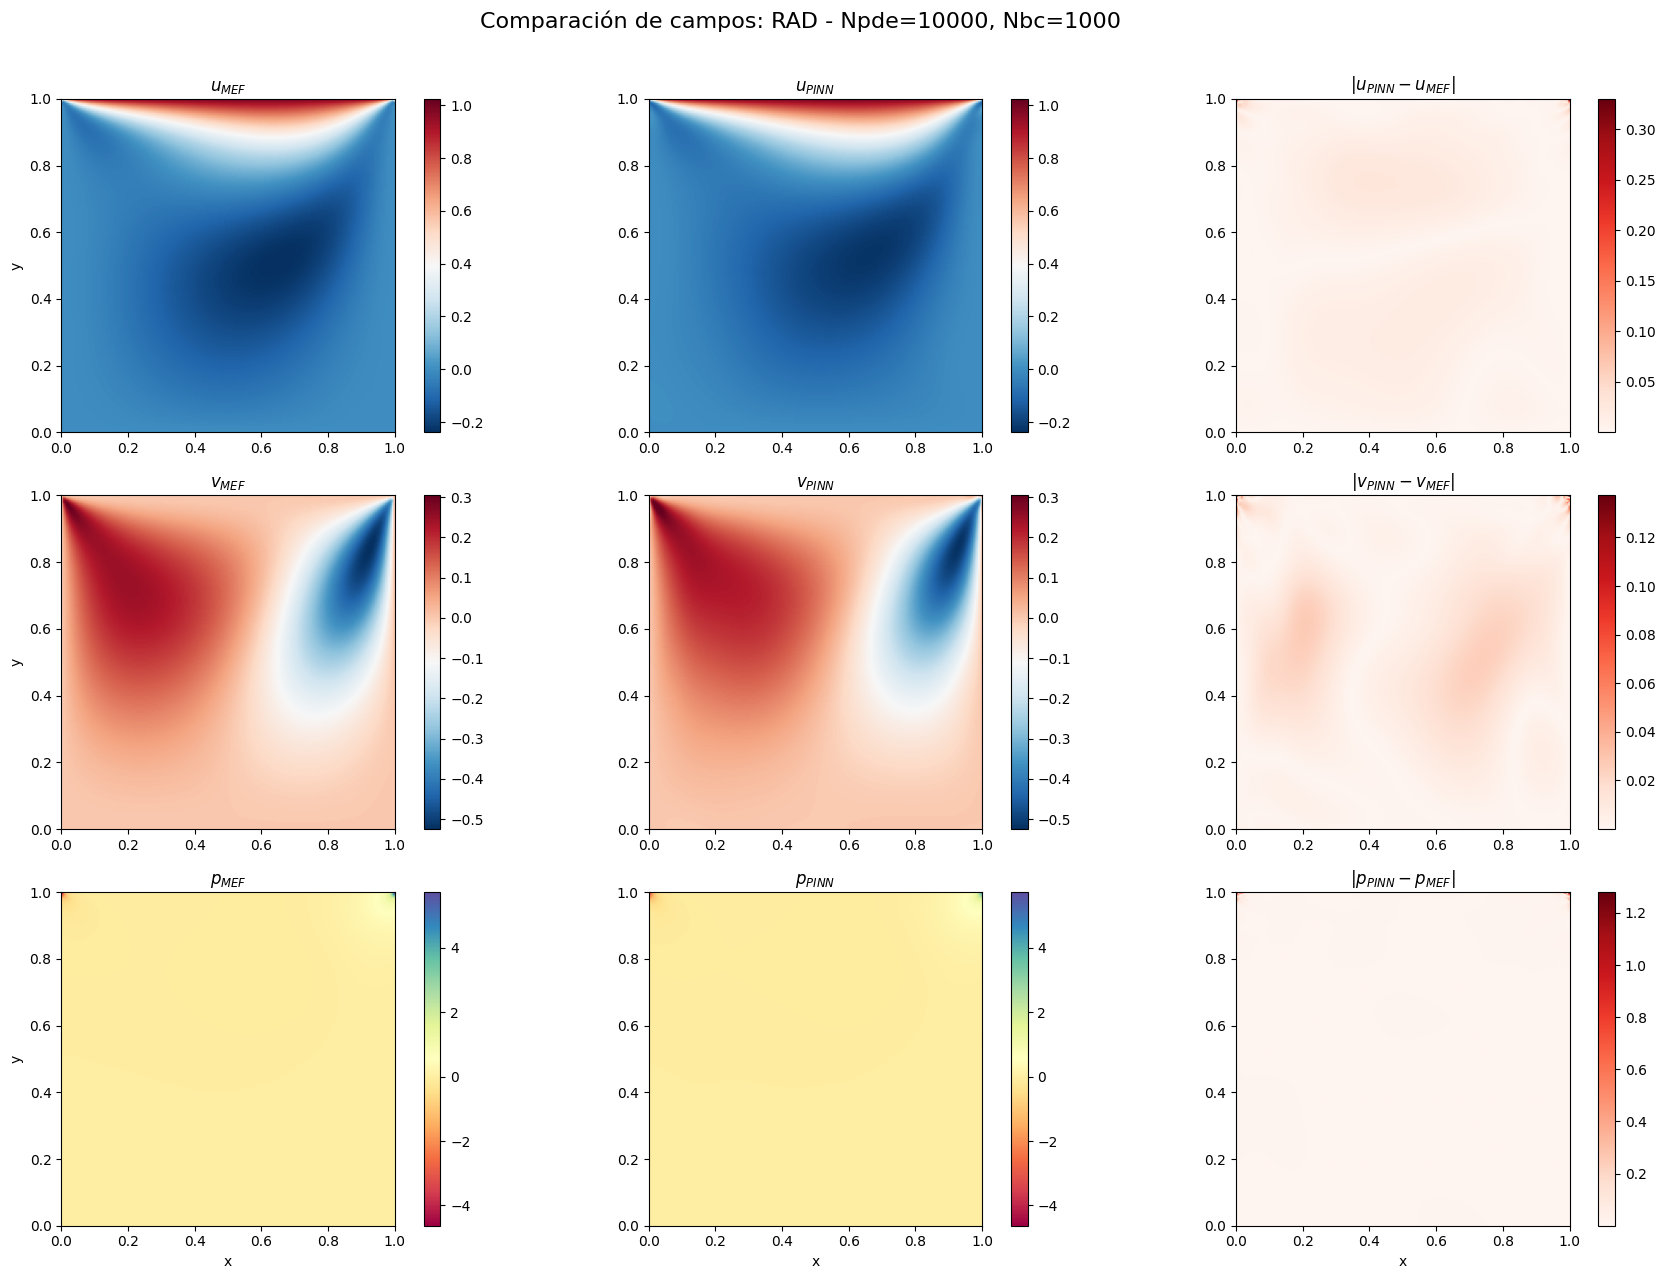


=== Entrenando modelo: rad_Npde100000_Nbc10000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 2/10000 [00:00<19:23,  8.59it/s]

Epoch    0 | Total: 9.42e+00 | PDE: 5.46e-01 | BC: 8.86e-01 | P_ref: 2.25e-02 | p(0,0): 0.2117 | u_top: 0.372


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:57<18:13,  8.68it/s]

Epoch  500 | Total: 3.29e-01 | PDE: 3.72e-02 | BC: 2.92e-02 | P_ref: 3.54e-07 | p(0,0): -0.0007 | u_top: 0.974


Entrenando modelo PINN:  10%|█         | 1002/10000 [01:54<16:55,  8.86it/s]

Epoch 1000 | Total: 2.11e-01 | PDE: 3.67e-02 | BC: 1.74e-02 | P_ref: 9.79e-07 | p(0,0): 0.0002 | u_top: 0.991


Entrenando modelo PINN:  15%|█▌        | 1502/10000 [02:50<15:45,  8.98it/s]

Epoch 1500 | Total: 1.45e-01 | PDE: 2.00e-02 | BC: 1.25e-02 | P_ref: 7.07e-07 | p(0,0): -0.0015 | u_top: 0.992


Entrenando modelo PINN:  20%|██        | 2002/10000 [03:47<15:06,  8.82it/s]

Epoch 2000 | Total: 1.14e-01 | PDE: 1.27e-02 | BC: 1.02e-02 | P_ref: 2.36e-06 | p(0,0): 0.0007 | u_top: 0.985


Entrenando modelo PINN:  25%|██▌       | 2502/10000 [04:44<14:01,  8.91it/s]

Epoch 2500 | Total: 1.01e-01 | PDE: 1.05e-02 | BC: 9.08e-03 | P_ref: 5.37e-07 | p(0,0): -0.0007 | u_top: 0.979


Entrenando modelo PINN:  30%|███       | 3002/10000 [05:40<13:08,  8.87it/s]

Epoch 3000 | Total: 9.38e-02 | PDE: 8.32e-03 | BC: 8.55e-03 | P_ref: 9.72e-07 | p(0,0): 0.0010 | u_top: 1.008


Entrenando modelo PINN:  35%|███▌      | 3502/10000 [06:36<12:08,  8.92it/s]

Epoch 3500 | Total: 7.95e-02 | PDE: 7.43e-03 | BC: 7.21e-03 | P_ref: 3.89e-07 | p(0,0): -0.0005 | u_top: 0.993


Entrenando modelo PINN:  40%|████      | 4002/10000 [07:32<11:11,  8.93it/s]

Epoch 4000 | Total: 7.41e-02 | PDE: 7.01e-03 | BC: 6.70e-03 | P_ref: 3.51e-09 | p(0,0): 0.0001 | u_top: 0.989


Entrenando modelo PINN:  45%|████▌     | 4502/10000 [08:29<10:34,  8.66it/s]

Epoch 4500 | Total: 7.15e-02 | PDE: 6.51e-03 | BC: 6.49e-03 | P_ref: 1.99e-06 | p(0,0): 0.0012 | u_top: 1.002


Entrenando modelo PINN:  50%|█████     | 5002/10000 [09:26<09:13,  9.03it/s]

Epoch 5000 | Total: 6.80e-02 | PDE: 7.92e-03 | BC: 6.01e-03 | P_ref: 1.28e-06 | p(0,0): -0.0008 | u_top: 0.999


Entrenando modelo PINN:  55%|█████▌    | 5502/10000 [10:22<08:33,  8.76it/s]

Epoch 5500 | Total: 6.17e-02 | PDE: 5.98e-03 | BC: 5.57e-03 | P_ref: 1.21e-07 | p(0,0): 0.0003 | u_top: 0.992


Entrenando modelo PINN:  60%|██████    | 6002/10000 [11:20<08:07,  8.20it/s]

Epoch 6000 | Total: 5.80e-02 | PDE: 5.43e-03 | BC: 5.26e-03 | P_ref: 3.33e-10 | p(0,0): 0.0000 | u_top: 0.994


Entrenando modelo PINN:  65%|██████▌   | 6502/10000 [12:16<06:28,  9.01it/s]

Epoch 6500 | Total: 5.52e-02 | PDE: 5.08e-03 | BC: 5.01e-03 | P_ref: 8.87e-08 | p(0,0): 0.0004 | u_top: 0.995


Entrenando modelo PINN:  70%|███████   | 7002/10000 [13:11<05:34,  8.97it/s]

Epoch 7000 | Total: 5.29e-02 | PDE: 4.84e-03 | BC: 4.81e-03 | P_ref: 3.38e-07 | p(0,0): 0.0004 | u_top: 0.995


Entrenando modelo PINN:  75%|███████▌  | 7502/10000 [14:07<04:35,  9.07it/s]

Epoch 7500 | Total: 5.15e-02 | PDE: 4.77e-03 | BC: 4.67e-03 | P_ref: 3.45e-07 | p(0,0): 0.0006 | u_top: 0.999


Entrenando modelo PINN:  80%|████████  | 8002/10000 [15:02<03:39,  9.12it/s]

Epoch 8000 | Total: 4.91e-02 | PDE: 4.73e-03 | BC: 4.44e-03 | P_ref: 6.66e-07 | p(0,0): -0.0007 | u_top: 0.992


Entrenando modelo PINN:  85%|████████▌ | 8502/10000 [15:58<02:46,  8.98it/s]

Epoch 8500 | Total: 4.71e-02 | PDE: 4.48e-03 | BC: 4.26e-03 | P_ref: 1.12e-08 | p(0,0): -0.0001 | u_top: 0.994


Entrenando modelo PINN:  90%|█████████ | 9002/10000 [16:54<01:56,  8.60it/s]

Epoch 9000 | Total: 4.56e-02 | PDE: 4.31e-03 | BC: 4.13e-03 | P_ref: 7.24e-10 | p(0,0): 0.0000 | u_top: 0.995


Entrenando modelo PINN:  95%|█████████▌| 9502/10000 [17:51<00:58,  8.46it/s]

Epoch 9500 | Total: 4.43e-02 | PDE: 4.17e-03 | BC: 4.01e-03 | P_ref: 1.79e-08 | p(0,0): 0.0001 | u_top: 0.996


Entrenando modelo PINN: 100%|██████████| 10000/10000 [18:49<00:00,  8.86it/s]


Epoch 9999 | Total: 4.30e-02 | PDE: 4.12e-03 | BC: 3.89e-03 | P_ref: 4.76e-09 | p(0,0): -0.0001 | u_top: 0.995

Tiempo total: 1129.2 segundos
Modelo guardado como: models/pinn_rad_Npde100000_Nbc10000_20250729_190640.pt
Plotting training losses for rad_Npde100000_Nbc10000


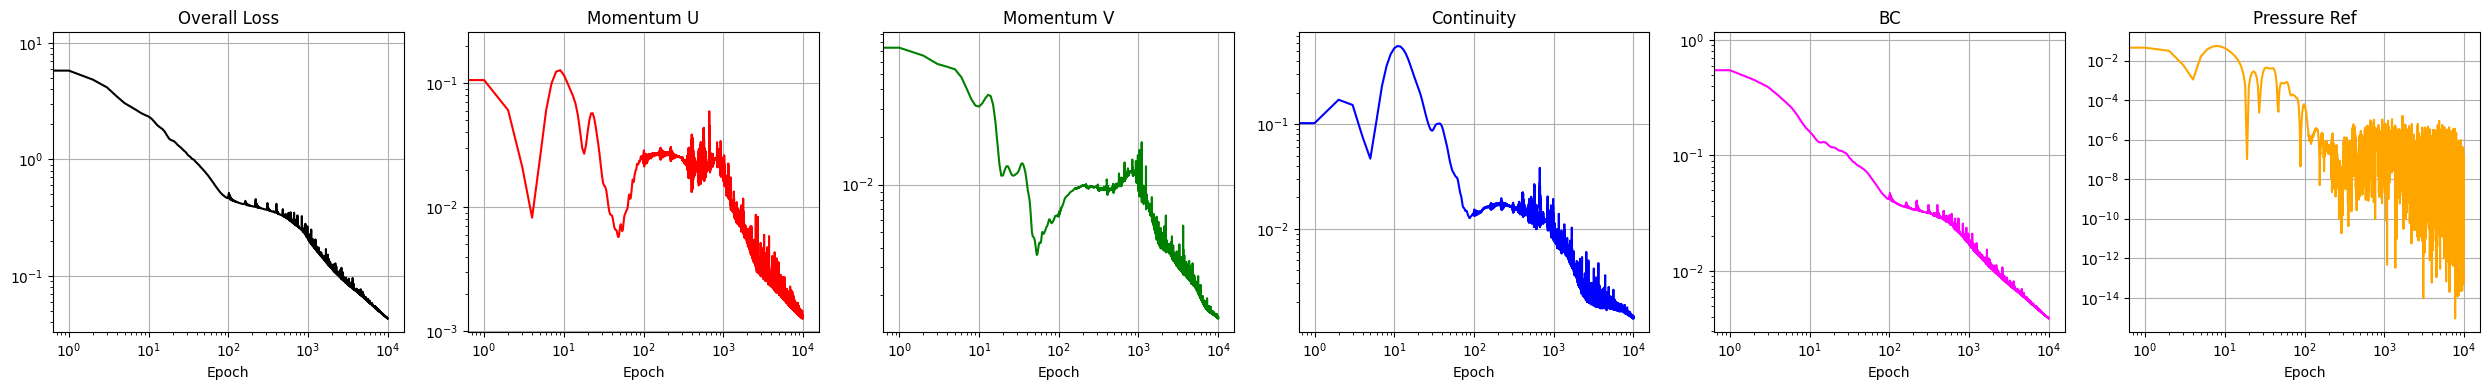

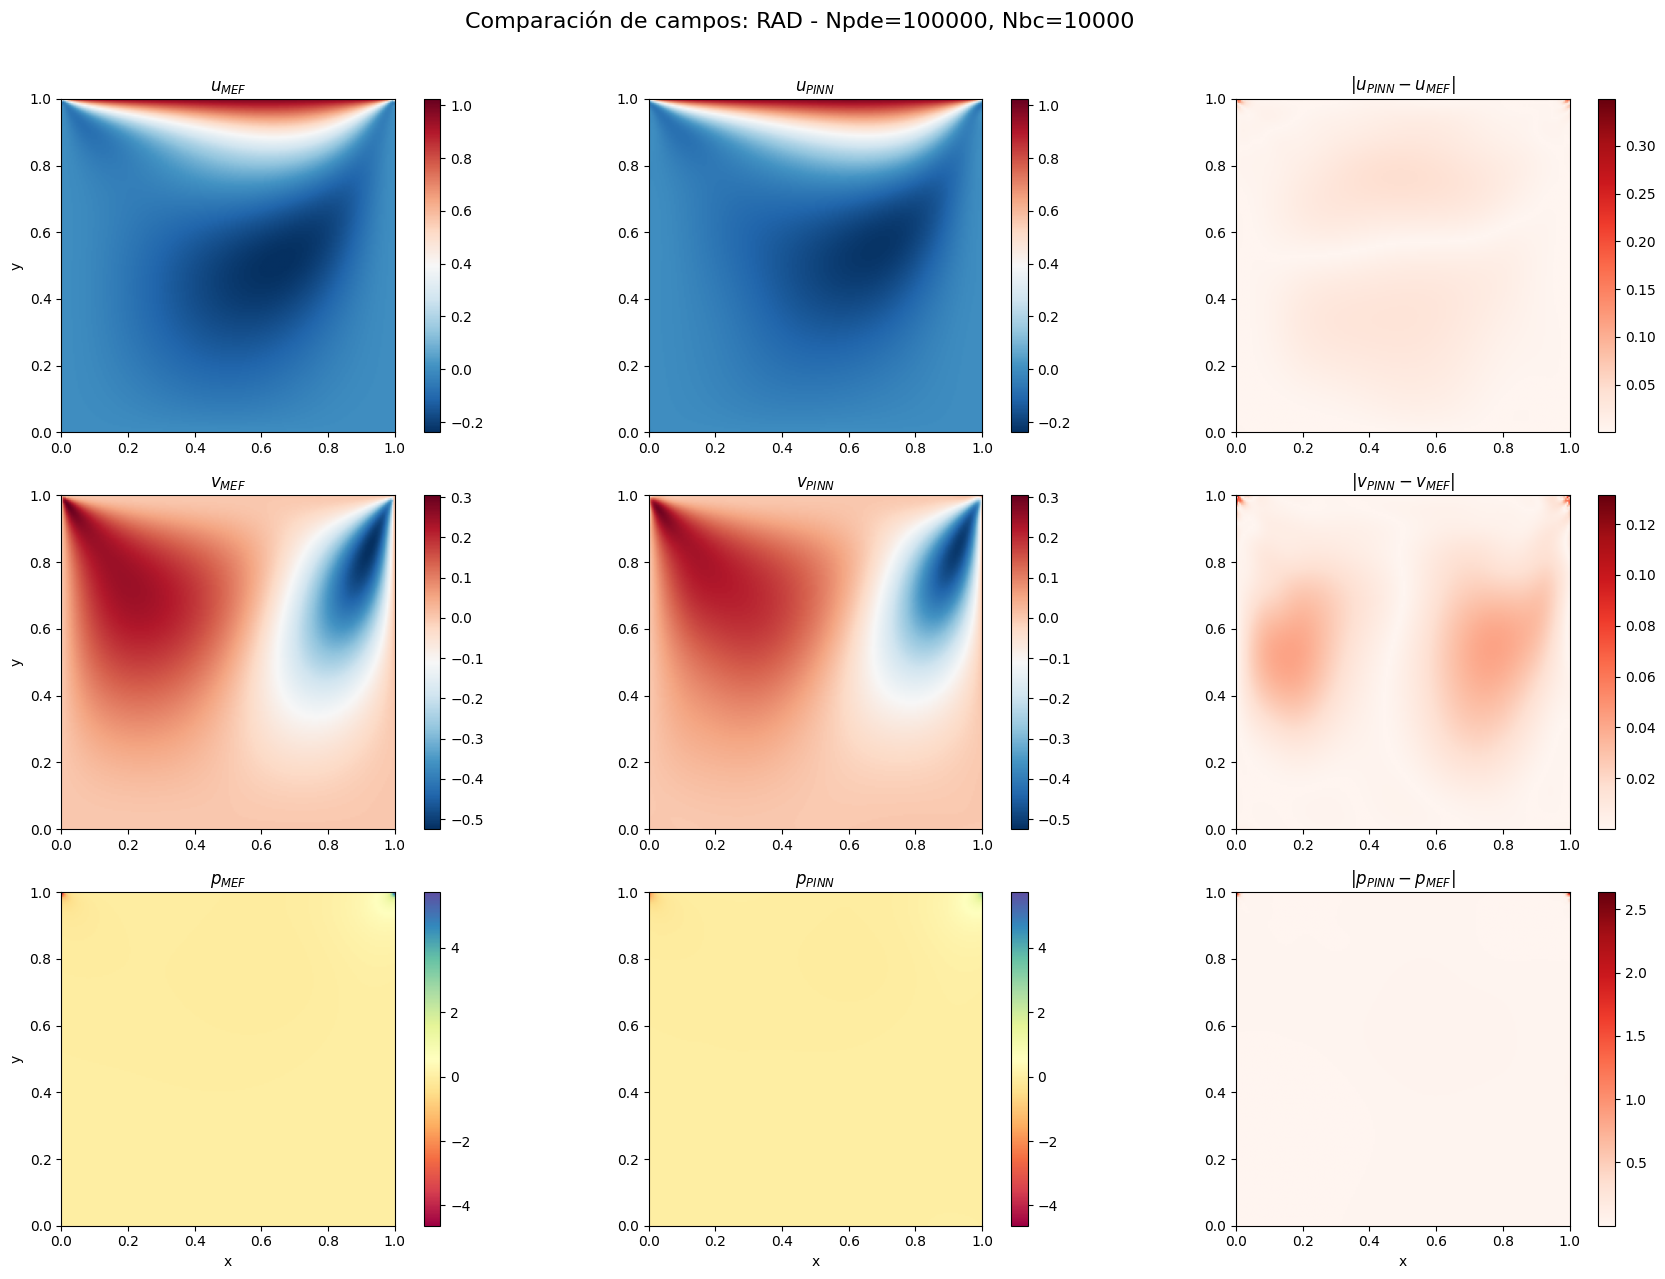

In [16]:
results = {}

error_metrics = {
    "strategy": [],
    "Npde": [],
    "Nbc": [],
    "error_u": [],
    "error_v": [],
    "error_p": [],
}

for strategy in strategies:
    for config in point_configs:
        Npde = config["Npde"]
        Nbc = config["Nbc"]
        key = f"{strategy}_Npde{Npde}_Nbc{Nbc}"

        print(f"\n=== Entrenando modelo: {key} ===")
        
        # Entrenar primero un modelo base para RAD
        if strategy == "rad" and f"uniform_Npde1000_Nbc100" not in results:
            print("Esperando modelo base uniform para usar en RAD...")
            continue  # saltar por ahora

        # Usar modelo base entrenado para RAD
        base_key = f"uniform_Npde{Npde}_Nbc{Nbc}"
        base_model = results.get(base_key, {}).get("model") if strategy == "rad" else None

        # Generar datos
        pde_points, bottom, top, left, right, bc_points = generate_collocation_points(
            strategy=strategy,
            N_pde=Npde,
            N_bc=Nbc,
            device=device,
            model=base_model
        )

        # Crear nuevo modelo
        torch.manual_seed(10)
        model = PINN_Module(model_parameters).to(device)

        # Optim y scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0017834604711425984, weight_decay=5.291425845841764e-07)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9996901505905309)

        # Entrenamiento
        losses = train_pinn(
            model, pde_points, top, bottom, left, right,
            epochs=10000, #TODO: change to 10k! just testing code functioning
            optimizer=optimizer,
            scheduler=scheduler,
            weight_pde=1.0,
            lambda_bc=10.0,                     # requerido por TP3
            weight_pressure_ref=1.0,       # alto peso para condición de referencia
            strategy=strategy,
            Npde=Npde,
            Nbc=Nbc
        )

        # Guardar resultados
        results[key] = {
            "model": model,
            "losses": losses,
        }

        # Graficar pérdidas
        print(f"Plotting training losses for {key}")
        plot_losses(losses)

        # Evaluación de errores en malla de referencia 
        model.eval()
        with torch.no_grad():
            uvp_pred = model(X_eval)
            u_pred = uvp_pred[:, 0].cpu().numpy().reshape(U_grid.shape)
            v_pred = uvp_pred[:, 1].cpu().numpy().reshape(V_grid.shape)
            p_pred = uvp_pred[:, 2].cpu().numpy().reshape(P_grid.shape)

        # Errores absolutos
        error_u = np.abs(u_pred - U_grid)
        error_v = np.abs(v_pred - V_grid)
        error_p = np.abs(p_pred - P_grid)

        # Normas-2 absolutas
        norm2_u = np.linalg.norm(error_u)
        norm2_v = np.linalg.norm(error_v)
        norm2_p = np.linalg.norm(error_p)

        plot_comparacion_uvp(
            u_pred, v_pred, p_pred,
            strategy, Npde, Nbc,
            U_grid, V_grid, P_grid,
            x, y
        )

        # Guardar en lista
        error_metrics["strategy"].append(strategy)
        error_metrics["Npde"].append(Npde)
        error_metrics["Nbc"].append(Nbc)
        error_metrics["error_u"].append(norm2_u)
        error_metrics["error_v"].append(norm2_v)
        error_metrics["error_p"].append(norm2_p)

### 4. Convergencia en cantidad de puntos de colocación. 

*Grafique los valores previamente calculados de la norma-2 del error en función del tamaño del dataset, en una gráfica doble logarítmica (loglog). ¿Observa un patrón de convergencia? ¿Es posible reportar una tasa de convergencia estable? ¿Cuál de todas las configuraciones alcanzó el mejor desempeño? ¿Es consistente esta conclusión con lo que usted esperaba? ¿Porqué si o porqué no?*

In [ ]:
df_errors = pd.DataFrame(error_metrics)
df_errors.to_csv(f"{graficas_dir}/error_metrics.csv", index=False)  # opcional
display(df_errors)

strategy    Npde    Nbc    error_u    error_v    error_p
0  uniform    1000    100   3.683855   3.367710  10.459689
1  uniform   10000   1000   1.788705   1.344256   2.716071
2  uniform  100000  10000   1.329674   1.300024   4.364383
3      lhs    1000    100   3.613037   5.005056  10.229439
4      lhs   10000   1000   1.460604   1.513435   4.640435
5      lhs  100000  10000   1.666695   1.662098   4.303720
6      rad    1000    100  41.788784  40.826856  34.569056
7      rad   10000   1000   2.351329   2.024828   2.673809
8      rad  100000  10000   3.676072   3.360083   5.908540

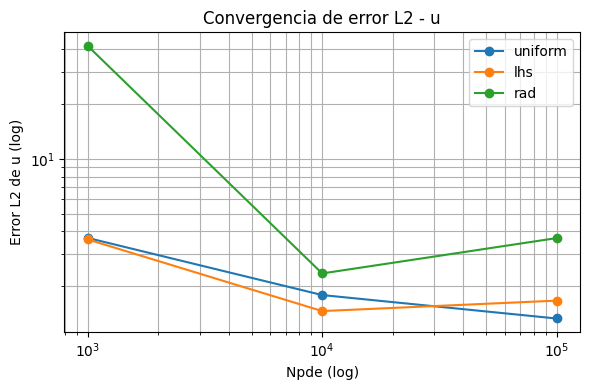

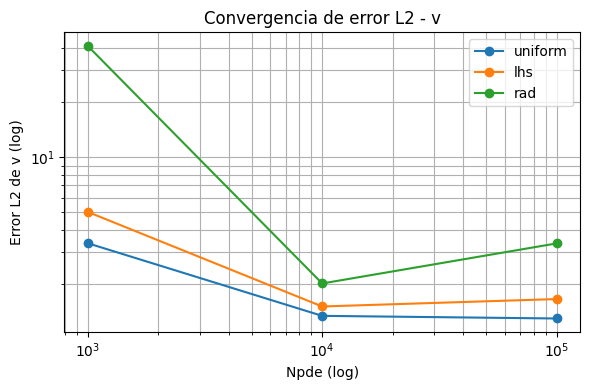

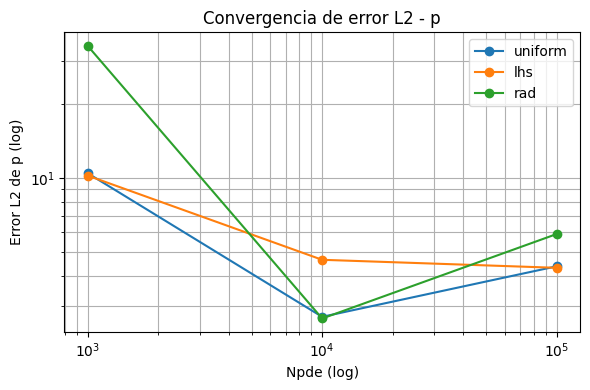

In [ ]:
variables = ["error_u", "error_v", "error_p"]
labels = ["u", "v", "p"]

for var, label in zip(variables, labels):
    plt.figure(figsize=(6, 4))
    for strategy in df_errors["strategy"].unique():
        subset = df_errors[df_errors["strategy"] == strategy]
        subset = subset.sort_values("Npde")
        plt.loglog(subset["Npde"], subset[var], marker='o', label=strategy)

    plt.xlabel("Npde (log)")
    plt.ylabel(f"Error L2 de {label} (log)")
    plt.title(f"Convergencia de error L2 - {label}")
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{graficas_dir}/convergencia_loglog_{label}.png")
    plt.show()

### Analizando las gráficas de convergencia y el dataframe de errores, podemos decir que:

Analizando los gráficos de convergencia del error L2 y los datos proporcionados, respondo a cada pregunta:

## 1. ¿Observa un patrón de convergencia?

**Sí, pero con comportamientos distintos según la estrategia:**

- **Uniform y LHS**: Muestran un patrón de convergencia más consistente, con disminución del error hasta ~10⁴ puntos, aunque no siempre monótona hacia 10⁵ puntos.
- **Rad**: Presenta un comportamiento errático, especialmente notable en el rango inicial donde comienza con errores muy altos para las tres variables.
- **Tendencia general**: Todas las estrategias tienden a converger hacia valores similares en el rango de 10⁴-10⁵ puntos.

## 2. ¿Es posible reportar una tasa de convergencia estable?

**No es posible reportar una tasa de convergencia estable** para ninguna de las estrategias. Los gráficos muestran:
- Convergencia no monótona (especialmente visible en la variable p)
- Fluctuaciones y aumentos ocasionales del error
- Comportamiento inconsistente entre diferentes rangos de Npde

## 3. ¿Cuál de todas las configuraciones alcanzó el mejor desempeño?

**La estrategia "uniform" alcanzó el mejor desempeño general:**
- **error_p**: 4.364383 (mejor)
- **error_u**: 1.329674 (mejor) 
- **error_v**: 1.300024 (mejor)

LHS ocupa el segundo lugar, mientras que rad muestra consistentemente los peores resultados.

## 4. ¿Es consistente esta conclusión con lo que usted esperaba?

**Parcialmente consistente.** Se esperaría que:
- **Uniform** fuera estable y confiable ✓
- **LHS** superara a uniform en problemas de alta dimensionalidad ✗
- **Random** fuera el menos eficiente ✓

## 5. ¿Por qué sí o por qué no?

**Las razones del comportamiento observado:**

- **Uniform superior a LHS**: Esto puede deberse a que el problema no tiene suficiente dimensionalidad para que LHS muestre sus ventajas, o que la distribución del problema favorece el muestreo regular.

- **Rad errático**: El muestreo puramente aleatorio produce distribuciones desiguales de puntos, creando "agujeros" y "clusters" que afectan la calidad de la aproximación.

- **Convergencia no monótona**: Sugiere que el método numérico puede estar alcanzando límites de precisión computacional o que existe ruido numérico que domina para valores altos de Npde.

La conclusión principal es que el muestreo uniforme proporciona la mejor estabilidad y precisión para este problema específico.